# Sarcasm Detection in Political Comments

In [ ]:
from google.colab import drive
import os
import sys

drive.mount("/content/drive")
base_dir = "/content/drive/MyDrive/SarcasmDetection"
sys.path.append(base_dir)
os.chdir(base_dir)
# data paths
train_data_balanced_path = os.path.join(base_dir, "train-balanced-sarcasm.csv")
test_data_balanced_path = os.path.join(base_dir, "test-balanced.csv")
test_data_unbalanced_path = os.path.join(base_dir, "test-unbalanced.csv")

Mounted at /content/drive


In [ ]:
# Import libraries and NLTK packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, f1_score, confusion_matrix, precision_score, recall_score

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import spacy
from wordcloud import WordCloud
import warnings
warnings.filterwarnings('ignore')

nltk.download('punkt_tab')
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

## 1. Data Loading and Exploration

In [ ]:
train_data_all = pd.read_csv(train_data_balanced_path)

# Get data from political subreddits only
political_subreddits = [
    "politics", "news", "worldnews", "HillaryForPrison", "progressive", "The_Donald",
    "ukpolitics", "conspiracy", "Libertarian", "worldpolitics", "EnoughTrumpSpam",
    "FULLCOMMUNISM", "WayOfTheBern", "PoliticalDiscussion", "uncensorednews",
    "LateStageCapitalism", "Anarchism", "Conservative", "DNCleaks", "TopMindsOfReddit",
    "Republican", "PoliticalVideo", "AskAnAmerican", "AmericanPolitics", "DebateFascism",
    "socialism", "Anarcho_Capitalism", "GenderCritical", "AskThe_Donald",
    "EnoughLibertarianSpam", "CanadaPolitics"
]

train_data = train_data_all[train_data_all['subreddit'].isin(political_subreddits)]
train_data = train_data.dropna(subset=['subreddit', 'comment', 'label', 'subreddit'])

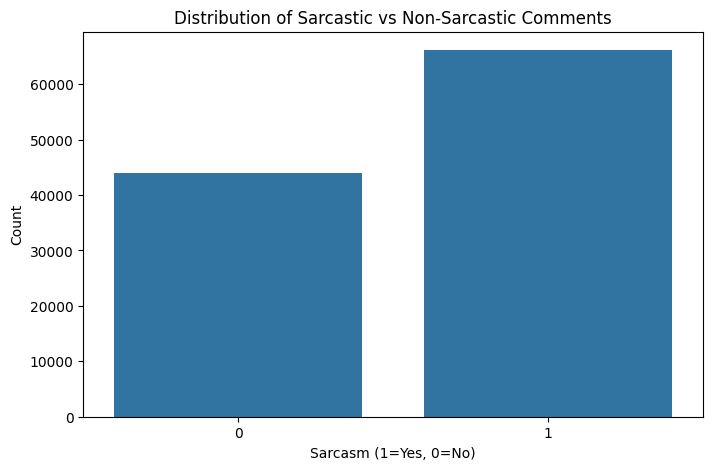

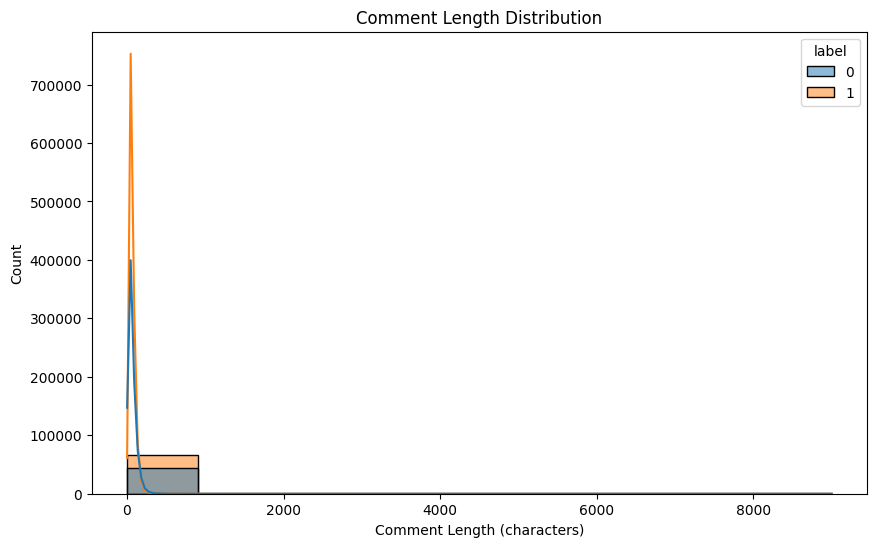

In [ ]:
# Check class distribution
plt.figure(figsize=(8, 5))
sns.countplot(x='label', data=train_data)
plt.title('Distribution of Sarcastic vs Non-Sarcastic Comments')
plt.xlabel('Sarcasm (1=Yes, 0=No)')
plt.ylabel('Count')
plt.show()

# Check comment length distribution
train_data['comment_length'] = train_data['comment'].fillna('').apply(len)
plt.figure(figsize=(10, 6))
sns.histplot(data=train_data, x='comment_length', hue='label', bins=10, kde=True)
plt.title('Comment Length Distribution')
plt.xlabel('Comment Length (characters)')
plt.ylabel('Count')
plt.show()

## 2. Text Preprocessing

In [ ]:
def preprocess_text(text):
    if isinstance(text, str):
        text = text.lower()
        # Remove special characters and digits
        text = re.sub(r'[^\w\s]', '', text)
        text = re.sub(r'\d+', '', text)
        # Tokenize
        tokens = word_tokenize(text)
        # Remove stopwords
        stop_words = set(stopwords.words('english'))
        tokens = [word for word in tokens if word not in stop_words and len(word) > 2]
        return ' '.join(tokens)
    else:
        return ''

train_data['processed_comment'] = train_data['comment'].apply(preprocess_text)

# Remove empty comments
train_data = train_data[train_data['processed_comment'].str.strip() != '']
print(f"Training data shape after preprocessing: {train_data.shape}")

Training data shape after preprocessing: (110136, 11)


## 3. Word Cloud Visualization

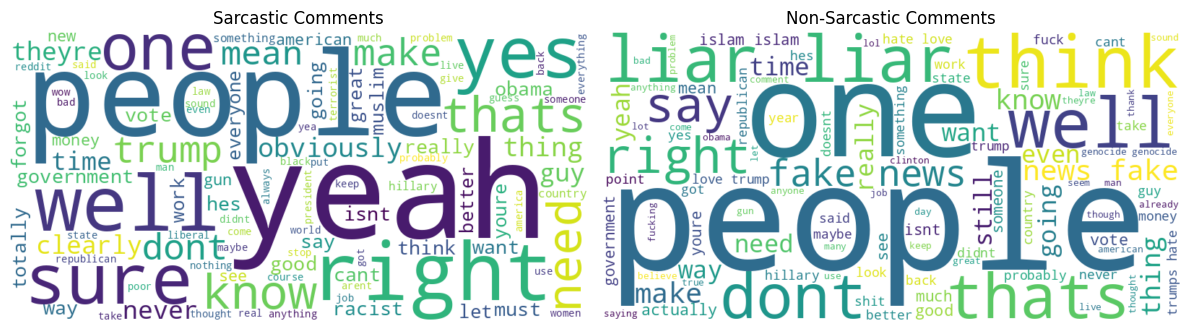

In [ ]:
sarcastic_text = ' '.join(train_data[train_data['label'] == 1]['processed_comment'])
non_sarcastic_text = ' '.join(train_data[train_data['label'] == 0]['processed_comment'])

plt.figure(figsize=(12, 6))

# Sarcastic word cloud
plt.subplot(1, 2, 1)
wordcloud_sarcastic = WordCloud(width=800, height=400, background_color='white', max_words=100, contour_width=3, contour_color='steelblue')
wordcloud_sarcastic.generate(sarcastic_text)
plt.imshow(wordcloud_sarcastic, interpolation='bilinear')
plt.title('Sarcastic Comments')
plt.axis('off')

# Non-sarcastic word cloud
plt.subplot(1, 2, 2)
wordcloud_non_sarcastic = WordCloud(width=800, height=400, background_color='white', max_words=100, contour_width=3, contour_color='firebrick')
wordcloud_non_sarcastic.generate(non_sarcastic_text)
plt.imshow(wordcloud_non_sarcastic, interpolation='bilinear')
plt.title('Non-Sarcastic Comments')
plt.axis('off')

plt.tight_layout()
plt.show()

## 4. Feature Extraction and Classification

#### Advanced Feature Engineering

In [ ]:
features_df = pd.DataFrame(index=train_data.index)

# 1. Linguistic-based features
def extract_linguistic_features(text):
    if not isinstance(text, str):
        return pd.Series({
            'exclamation_count': 0, 'question_count': 0, 'caps_ratio': 0,
            'ellipsis_count': 0, 'quote_count': 0, 'word_count': 0,
            'avg_word_length': 0, 'unique_words_ratio': 0
        })

    exclamation_count = text.count('!')
    question_count = text.count('?')
    quote_count = text.count('"') + text.count("'")
    ellipsis_count = text.count('...')

    # Word-based features
    words = text.split()
    word_count = len(words)
    if word_count == 0:
        return pd.Series({
            'exclamation_count': exclamation_count,
            'question_count': question_count,
            'caps_ratio': 0,
            'ellipsis_count': ellipsis_count,
            'quote_count': quote_count,
            'word_count': 0,
            'avg_word_length': 0,
            'unique_words_ratio': 0
        })

    # Capitalization ratio
    caps_words = sum(1 for word in words if word.isupper() and len(word) > 1)
    caps_ratio = caps_words / word_count if word_count > 0 else 0

    # Average word length and unique words ratio
    avg_word_length = sum(len(word) for word in words) / word_count if word_count > 0 else 0
    unique_words = len(set(words))
    unique_words_ratio = unique_words / word_count if word_count > 0 else 0

    return pd.Series({
        'exclamation_count': exclamation_count,
        'question_count': question_count,
        'caps_ratio': caps_ratio,
        'ellipsis_count': ellipsis_count,
        'quote_count': quote_count,
        'word_count': word_count,
        'avg_word_length': avg_word_length,
        'unique_words_ratio': unique_words_ratio
    })

linguistic_features = train_data['comment'].apply(extract_linguistic_features)
for column in linguistic_features.columns:
    features_df[column] = linguistic_features[column]

# 2. Sarcasm-specific features
def extract_sarcasm_markers(text):
    if not isinstance(text, str):
        return pd.Series({
            'intensifier_count': 0, 'contrast_words': 0, 'lol_count': 0,
            'exaggeration_count': 0, 'quotation_marks': 0, 'has_emoticon': 0
        })

    # Intensifiers
    intensifiers = ['really', 'very', 'so', 'totally', 'absolutely', 'completely', 'literally', 'actually']
    intensifier_count = sum(1 for word in intensifiers if re.search(r'\b' + word + r'\b', text.lower()))

    # Contrast words
    contrast_words_list = ['but', 'however', 'although', 'though', 'yet', 'nonetheless', 'nevertheless']
    contrast_words = sum(1 for word in contrast_words_list if re.search(r'\b' + word + r'\b', text.lower()))

    # Internet slang
    lol_count = sum(1 for pattern in [r'\blol\b', r'\blomfl\b', r'\brotfl\b', r'\blmao\b', r'\bhaha\b']
                    if re.search(pattern, text.lower()))

    # Exaggeration patterns
    exaggeration_patterns = [
        r'\b(\w)\1{2,}',
        r'\bsuuuure\b', r'\briiight\b', r'\bsuuure\b', r'\byeaah\b',
        r'\bdefinitely\b.*\bnot\b', r'\bobviously\b', r'\bclearly\b'
    ]
    exaggeration_count = sum(1 for pattern in exaggeration_patterns
                             if re.search(pattern, text.lower()))

    # Quotation marks for emphasis or distancing
    quotation_marks = sum(1 for pattern in ['"', "'", """, """] if pattern in text)

    # Emoticons
    emoticon_patterns = [r'[:;]-?[)D]', r'[:;]-?[(]', r'[xX]D', r':-?[pP]']
    has_emoticon = any(re.search(pattern, text) for pattern in emoticon_patterns)

    return pd.Series({
        'intensifier_count': intensifier_count,
        'contrast_words': contrast_words,
        'lol_count': lol_count,
        'exaggeration_count': exaggeration_count,
        'quotation_marks': quotation_marks,
        'has_emoticon': int(has_emoticon)
    })

sarcasm_features = train_data['comment'].apply(extract_sarcasm_markers)
for column in sarcasm_features.columns:
    features_df[column] = sarcasm_features[column]

# 3. Sentiment analysis features
from textblob import TextBlob

def extract_sentiment_features(text):
    if not isinstance(text, str) or text.strip() == '':
        return pd.Series({
            'sentiment_polarity': 0, 'sentiment_subjectivity': 0,
            'sentiment_contrast': 0, 'sentiment_std': 0
        })

    # Overall sentiment
    blob = TextBlob(text)
    polarity = blob.sentiment.polarity
    subjectivity = blob.sentiment.subjectivity

    # Sentence-level sentiment analysis for contrast detection
    sentences = [str(sentence) for sentence in blob.sentences]
    if len(sentences) <= 1:
        return pd.Series({
            'sentiment_polarity': polarity,
            'sentiment_subjectivity': subjectivity,
            'sentiment_contrast': 0,
            'sentiment_std': 0
        })

    # Calculate sentiment for each sentence
    sentence_polarities = [TextBlob(sentence).sentiment.polarity for sentence in sentences]

    # Standard deviation of sentiment across sentences
    sentiment_std = np.std(sentence_polarities) if len(sentence_polarities) > 0 else 0

    # Check for sentiment contrast (+ to - and vice versa)
    has_positive = any(polarity > 0.2 for polarity in sentence_polarities)
    has_negative = any(polarity < -0.2 for polarity in sentence_polarities)
    sentiment_contrast = 1 if has_positive and has_negative else 0

    return pd.Series({
        'sentiment_polarity': polarity,
        'sentiment_subjectivity': subjectivity,
        'sentiment_contrast': sentiment_contrast,
        'sentiment_std': sentiment_std
    })

sentiment_features = train_data['comment'].apply(extract_sentiment_features)
for column in sentiment_features.columns:
    features_df[column] = sentiment_features[column]

# 4. Contextual features from subreddit data
subreddit_sarcasm_rates = train_data.groupby('subreddit')['label'].mean()
train_data['subreddit_sarcasm_rate'] = train_data['subreddit'].map(subreddit_sarcasm_rates)
features_df['subreddit_sarcasm_rate'] = train_data['subreddit_sarcasm_rate']

# 6. Readability and complexity metrics
def extract_readability_features(text):
    if not isinstance(text, str) or text.strip() == '':
        return pd.Series({
            'avg_sentence_length': 0, 'readability_score': 0
        })

    # Split into sentences
    sentences = re.split(r'[.!?]+', text)
    sentences = [s.strip() for s in sentences if s.strip()]

    if not sentences:
        return pd.Series({
            'avg_sentence_length': 0, 'readability_score': 0
        })

    # Average sentence length
    words_per_sentence = [len(re.findall(r'\b\w+\b', s)) for s in sentences]
    avg_sentence_length = sum(words_per_sentence) / len(sentences) if sentences else 0

    # Simple readability score (approx. of Flesch-Kincaid)
    total_words = sum(words_per_sentence)
    total_syllables = 0

    for sentence in sentences:
        words = re.findall(r'\b\w+\b', sentence.lower())
        for word in words:
            vowels = re.findall(r'[aeiouy]+', word)
            syllables = len(vowels)
            if word.endswith('e'):
                syllables = max(1, syllables - 1)
            if syllables == 0:
                syllables = 1
            total_syllables += syllables

    if total_words == 0 or len(sentences) == 0:
        readability_score = 0
    else:
        # Simple readability score calculation
        readability_score = 206.835 - (1.015 * (total_words / len(sentences))) - (84.6 * (total_syllables / total_words))
        # Normalize to 0-1 range
        readability_score = max(0, min(100, readability_score)) / 100

    return pd.Series({
        'avg_sentence_length': avg_sentence_length,
        'readability_score': readability_score
    })

readability_features = train_data['comment'].apply(extract_readability_features)
for column in readability_features.columns:
    features_df[column] = readability_features[column]

print("\nAdvanced feature engineering complete.")
train_data = pd.concat([train_data, features_df], axis=1)


Advanced feature engineering complete.


#### Overhead

In [ ]:
from time import time

train_data, test_data = train_test_split(train_data, test_size=0.2, random_state=42, stratify=train_data['label'])
train_data, val_data = train_test_split(train_data, test_size=0.2, random_state=42, stratify=train_data['label'])

# Get texts
X_train_text = train_data['processed_comment']
X_val_text = val_data['processed_comment']

# Get engineered features
feature_columns = features_df.columns
X_train_features = train_data[feature_columns].values
X_val_features = val_data[feature_columns].values

# Get labels
y_train = train_data['label']
y_val = val_data['label']

print(f"Training set size: {len(X_train_text)}, Validation set size: {len(X_val_text)}, Test set size: {len(test_data)}")
print(f"Class distribution in training: {np.bincount(y_train)}")
print(f"Class distribution in validation: {np.bincount(y_val)}")
print(f"Class distribution in test: {np.bincount(test_data['label'])}")

model_results = {
    'Model': [],
    'Accuracy': [],
    'F1 Score': [],
    'Precision': [],
    'Recall': [],
    'Training Time': []
}

Training set size: 70486, Validation set size: 17622, Test set size: 22028
Class distribution in training: [28147 42339]
Class distribution in validation: [ 7037 10585]
Class distribution in test: [ 8797 13231]


#### Approach 1: Bag of Words (BoW)

##### Without Advanced Features (trained on raw tokens)

In [ ]:
from scipy.sparse import hstack
bow_vectorizer = CountVectorizer(max_features=5000)
X_train_bow = bow_vectorizer.fit_transform(X_train_text)
X_val_bow = bow_vectorizer.transform(X_val_text)

# Train Logistic Regression with BoW features
bow_model = LogisticRegression(C=1.0, max_iter=1000, random_state=42)
bow_model.fit(X_train_bow, y_train)

# Evaluate on validation set
y_val_pred_bow = bow_model.predict(X_val_bow)
print("Bag of Words Model Evaluation:")
print(f"Accuracy: {accuracy_score(y_val, y_val_pred_bow):.4f}")
print(f"F1 Score (weighted): {f1_score(y_val, y_val_pred_bow, average='weighted'):.4f}")
print("\nClassification Report:")
print(classification_report(y_val, y_val_pred_bow))

Bag of Words Model Evaluation:
Accuracy: 0.6915
F1 Score (weighted): 0.6880

Classification Report:
              precision    recall  f1-score   support

           0     0.6277    0.5592    0.5915      7037
           1     0.7268    0.7795    0.7522     10585

    accuracy                         0.6915     17622
   macro avg     0.6772    0.6693    0.6718     17622
weighted avg     0.6872    0.6915    0.6880     17622



##### With advanced features

In [ ]:
from scipy.sparse import hstack
bow_vectorizer = CountVectorizer(max_features=5000)
X_train_bow = bow_vectorizer.fit_transform(X_train_text)
X_val_bow = bow_vectorizer.transform(X_val_text)

# Combine with engineered features
X_train_combined_bow = hstack([X_train_bow, X_train_features])
X_val_combined_bow = hstack([X_val_bow, X_val_features])

# Train Logistic Regression
bow_model = LogisticRegression(C=1.0, max_iter=1000, random_state=42)
bow_model.fit(X_train_combined_bow, y_train)

# Evaluate on validation set
y_val_pred_bow = bow_model.predict(X_val_combined_bow)
print("Bag of Words Model Evaluation:")
print(f"Accuracy: {accuracy_score(y_val, y_val_pred_bow):.4f}")
print(f"F1 Score (weighted): {f1_score(y_val, y_val_pred_bow, average='weighted'):.4f}")
print("\nClassification Report:")
print(classification_report(y_val, y_val_pred_bow))

Bag of Words Model Evaluation:
Accuracy: 0.7116
F1 Score (weighted): 0.7094

Classification Report:
              precision    recall  f1-score   support

           0     0.6509    0.5991    0.6239      7037
           1     0.7469    0.7864    0.7661     10585

    accuracy                         0.7116     17622
   macro avg     0.6989    0.6928    0.6950     17622
weighted avg     0.7086    0.7116    0.7094     17622



#### Approach 2: TF-IDF

##### Without Advanced Features (trained on raw tokens)

In [ ]:
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train_text)
X_val_tfidf = tfidf_vectorizer.transform(X_val_text)

# Train
tfidf_model = LogisticRegression(C=1.0, max_iter=1000, random_state=42)
tfidf_model.fit(X_train_tfidf, y_train)

# Evaluate
y_val_pred_tfidf = tfidf_model.predict(X_val_tfidf)
print("\nTF-IDF Model Evaluation:")
print(f"Accuracy: {accuracy_score(y_val, y_val_pred_tfidf):.4f}")
print(f"F1 Score (weighted): {f1_score(y_val, y_val_pred_tfidf, average='weighted'):.4f}")
print("\nClassification Report:")
print(classification_report(y_val, y_val_pred_tfidf))


TF-IDF Model Evaluation:
Accuracy: 0.6949
F1 Score (weighted): 0.6899

Classification Report:
              precision    recall  f1-score   support

           0       0.64      0.55      0.59      7037
           1       0.72      0.79      0.76     10585

    accuracy                           0.69     17622
   macro avg       0.68      0.67      0.67     17622
weighted avg       0.69      0.69      0.69     17622



##### With advanced features

In [ ]:
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train_text)
X_val_tfidf = tfidf_vectorizer.transform(X_val_text)

# Combine
X_train_combined_tfidf = hstack([X_train_tfidf, X_train_features])
X_val_combined_tfidf = hstack([X_val_tfidf, X_val_features])

# Train
tfidf_model = LogisticRegression(C=1.0, max_iter=1000, random_state=42)
tfidf_model.fit(X_train_combined_tfidf, y_train)

# Evaluate
y_val_pred_tfidf = tfidf_model.predict(X_val_combined_tfidf)
print("\nTF-IDF Model Evaluation:")
print(f"Accuracy: {accuracy_score(y_val, y_val_pred_tfidf):.4f}")
print(f"F1 Score (weighted): {f1_score(y_val, y_val_pred_tfidf, average='weighted'):.4f}")
print("\nClassification Report:")
print(classification_report(y_val, y_val_pred_tfidf))


TF-IDF Model Evaluation:
Accuracy: 0.7123
F1 Score (weighted): 0.7090

Classification Report:
              precision    recall  f1-score   support

           0       0.66      0.58      0.62      7037
           1       0.74      0.80      0.77     10585

    accuracy                           0.71     17622
   macro avg       0.70      0.69      0.69     17622
weighted avg       0.71      0.71      0.71     17622



#### Approach 3: TF-IDF with N-grams (Unigrams and Bigrams)


##### Without Advanced Features (trained on raw tokens)

In [ ]:
tfidf_ngram_vectorizer = TfidfVectorizer(max_features=7000, ngram_range=(1, 3))
X_train_tfidf_ngram = tfidf_vectorizer.fit_transform(X_train_text)
X_val_tfidf_ngram = tfidf_vectorizer.transform(X_val_text)

# Train
tfidf_ngram_model = LogisticRegression(C=1.0, max_iter=1000, random_state=42)
tfidf_ngram_model.fit(X_train_tfidf_ngram, y_train)


# Evaluate
y_val_pred_tfidf_ngram = tfidf_ngram_model.predict(X_val_tfidf_ngram)
print("\nTF-IDF N-gram Model Evaluation:")
print(f"Accuracy: {accuracy_score(y_val, y_val_pred_tfidf_ngram):.4f}")
print(f"F1 Score (weighted): {f1_score(y_val, y_val_pred_tfidf_ngram, average='weighted'):.4f}")
print("\nClassification Report (TF-IDF N-gram):")
print(classification_report(y_val, y_val_pred_tfidf_ngram))


TF-IDF N-gram Model Evaluation:
Accuracy: 0.6949
F1 Score (weighted): 0.6899

Classification Report (TF-IDF N-gram):
              precision    recall  f1-score   support

           0       0.64      0.55      0.59      7037
           1       0.72      0.79      0.76     10585

    accuracy                           0.69     17622
   macro avg       0.68      0.67      0.67     17622
weighted avg       0.69      0.69      0.69     17622



##### With Advanced Features

In [ ]:
tfidf_ngram_vectorizer = TfidfVectorizer(max_features=7000, ngram_range=(1, 3))
X_train_tfidf_ngram = tfidf_vectorizer.fit_transform(X_train_text)
X_val_tfidf_ngram = tfidf_vectorizer.transform(X_val_text)

# Combine
X_train_combined_tfidf_ngram = hstack([X_train_tfidf, X_train_features])
X_val_combined_tfidf_ngram = hstack([X_val_tfidf, X_val_features])

# Train
tfidf_ngram_model = LogisticRegression(C=1.0, max_iter=1000, random_state=42)
tfidf_ngram_model.fit(X_train_combined_tfidf_ngram, y_train)


# Evaluate
y_val_pred_tfidf_ngram = tfidf_ngram_model.predict(X_val_combined_tfidf_ngram)
print("\nTF-IDF N-gram Model Evaluation:")
print(f"Accuracy: {accuracy_score(y_val, y_val_pred_tfidf_ngram):.4f}")
print(f"F1 Score (weighted): {f1_score(y_val, y_val_pred_tfidf_ngram, average='weighted'):.4f}")
print("\nClassification Report (TF-IDF N-gram):")
print(classification_report(y_val, y_val_pred_tfidf_ngram))


TF-IDF N-gram Model Evaluation:
Accuracy: 0.7123
F1 Score (weighted): 0.7090

Classification Report (TF-IDF N-gram):
              precision    recall  f1-score   support

           0       0.66      0.58      0.62      7037
           1       0.74      0.80      0.77     10585

    accuracy                           0.71     17622
   macro avg       0.70      0.69      0.69     17622
weighted avg       0.71      0.71      0.71     17622



#### Approach 4: Using hyperparameter tuning for TF-IDF with N-grams

##### Without Advanced Features

In [ ]:
from sklearn.model_selection import GridSearchCV

# Grid search
param_grid = {
    'C': [0.1, 1.0, 10.0],
    'class_weight': [None, 'balanced'],
    'solver': ['liblinear', 'saga']
}

grid_search = GridSearchCV(
    LogisticRegression(max_iter=1000, random_state=42),
    param_grid,
    cv=3,
    scoring='f1_weighted',
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train_tfidf_ngram, y_train)

print(f"\nBest parameters: {grid_search.best_params_}")
print(f"Best cross-validation score: {grid_search.best_score_:.4f}")

# Train model with best parameters
best_lr_model = LogisticRegression(**grid_search.best_params_, max_iter=1000, random_state=42)
best_lr_model.fit(X_train_tfidf_ngram, y_train)

# Evaluate on validation set
y_val_pred_best = best_lr_model.predict(X_val_tfidf_ngram)
print("\nTuned TF-IDF N-gram Model Evaluation:")
print(f"Accuracy: {accuracy_score(y_val, y_val_pred_best):.4f}")
print(f"F1 Score (weighted): {f1_score(y_val, y_val_pred_best, average='weighted'):.4f}")
print("\nClassification Report (Tuned TF-IDF N-gram):")
print(classification_report(y_val, y_val_pred_best))

Fitting 3 folds for each of 12 candidates, totalling 36 fits

Best parameters: {'C': 1.0, 'class_weight': None, 'solver': 'liblinear'}
Best cross-validation score: 0.6850

Tuned TF-IDF N-gram Model Evaluation:
Accuracy: 0.6953
F1 Score (weighted): 0.6904

Classification Report (Tuned TF-IDF N-gram):
              precision    recall  f1-score   support

           0       0.64      0.55      0.59      7037
           1       0.72      0.79      0.76     10585

    accuracy                           0.70     17622
   macro avg       0.68      0.67      0.67     17622
weighted avg       0.69      0.70      0.69     17622



##### With Advanced Features (trained on raw tokens)

In [ ]:
from sklearn.model_selection import GridSearchCV

# Grid search
param_grid = {
    'C': [0.1, 1.0, 10.0],
    'class_weight': [None, 'balanced'],
    'solver': ['liblinear', 'saga']
}

grid_search = GridSearchCV(
    LogisticRegression(max_iter=1000, random_state=42),
    param_grid,
    cv=3,
    scoring='f1_weighted',
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train_combined_tfidf_ngram, y_train)

print(f"\nBest parameters: {grid_search.best_params_}")
print(f"Best cross-validation score: {grid_search.best_score_:.4f}")

# Train model with best parameters
best_lr_model = LogisticRegression(**grid_search.best_params_, max_iter=1000, random_state=42)
best_lr_model.fit(X_train_combined_tfidf_ngram, y_train)

# Evaluate on validation set
y_val_pred_best = best_lr_model.predict(X_val_combined_tfidf_ngram)
print("\nTuned TF-IDF N-gram Model Evaluation:")
print(f"Accuracy: {accuracy_score(y_val, y_val_pred_best):.4f}")
print(f"F1 Score (weighted): {f1_score(y_val, y_val_pred_best, average='weighted'):.4f}")
print("\nClassification Report (Tuned TF-IDF N-gram):")
print(classification_report(y_val, y_val_pred_best))

Fitting 3 folds for each of 12 candidates, totalling 36 fits

Best parameters: {'C': 1.0, 'class_weight': None, 'solver': 'liblinear'}
Best cross-validation score: 0.7069

Tuned TF-IDF N-gram Model Evaluation:
Accuracy: 0.7126
F1 Score (weighted): 0.7092

Classification Report (Tuned TF-IDF N-gram):
              precision    recall  f1-score   support

           0       0.66      0.58      0.62      7037
           1       0.74      0.80      0.77     10585

    accuracy                           0.71     17622
   macro avg       0.70      0.69      0.69     17622
weighted avg       0.71      0.71      0.71     17622



#### Approach 5: Ensemble Method - Voting Classifier

##### Without Advanced Features (trained on raw tokens)

In [ ]:
from sklearn.ensemble import VotingClassifier

# Create ensemble model
ensemble_model = VotingClassifier(
    estimators=[
        ('bow', LogisticRegression(C=1.0, max_iter=1000, random_state=42)),
        ('tfidf', LogisticRegression(C=1.0, max_iter=1000, random_state=42)),
        ('tfidf_ngram', best_lr_model)
    ],
    voting='soft'
)

# Convert sparse matrices to dense for the ensemble
X_train_combined = hstack([X_train_bow, X_train_tfidf, X_train_tfidf_ngram]).toarray()
X_val_combined = hstack([X_val_bow, X_val_tfidf, X_val_tfidf_ngram]).toarray()

ensemble_model.fit(X_train_combined, y_train)

# Evaluate ensemble on validation set
y_val_pred_ensemble = ensemble_model.predict(X_val_combined)
print("\nEnsemble Model Evaluation:")
print(f"Accuracy: {accuracy_score(y_val, y_val_pred_ensemble):.4f}")
print(f"F1 Score (weighted): {f1_score(y_val, y_val_pred_ensemble, average='weighted'):.4f}")
print("\nClassification Report (Ensemble):")
print(classification_report(y_val, y_val_pred_ensemble))


Ensemble Model Evaluation:
Accuracy: 0.6983
F1 Score (weighted): 0.6951

Classification Report (Ensemble):
              precision    recall  f1-score   support

           0       0.64      0.57      0.60      7037
           1       0.73      0.78      0.76     10585

    accuracy                           0.70     17622
   macro avg       0.68      0.68      0.68     17622
weighted avg       0.69      0.70      0.70     17622



##### With Advanced Features

In [ ]:
from sklearn.ensemble import VotingClassifier

# Create ensemble model
ensemble_model = VotingClassifier(
    estimators=[
        ('bow', LogisticRegression(C=1.0, max_iter=1000, random_state=42)),
        ('tfidf', LogisticRegression(C=1.0, max_iter=1000, random_state=42)),
        ('tfidf_ngram', best_lr_model)
    ],
    voting='soft'
)

# Convert sparse matrices to dense for the ensemble
X_train_combined = hstack([X_train_combined_bow, X_train_combined_tfidf, X_train_combined_tfidf_ngram]).toarray()
X_val_combined = hstack([X_val_combined_bow, X_val_combined_tfidf, X_val_combined_tfidf_ngram]).toarray()

ensemble_model.fit(X_train_combined, y_train)

# Evaluate ensemble on validation set
y_val_pred_ensemble = ensemble_model.predict(X_val_combined)
print("\nEnsemble Model Evaluation:")
print(f"Accuracy: {accuracy_score(y_val, y_val_pred_ensemble):.4f}")
print(f"F1 Score (weighted): {f1_score(y_val, y_val_pred_ensemble, average='weighted'):.4f}")
print("\nClassification Report (Ensemble):")
print(classification_report(y_val, y_val_pred_ensemble))


Ensemble Model Evaluation:
Accuracy: 0.7123
F1 Score (weighted): 0.7099

Classification Report (Ensemble):
              precision    recall  f1-score   support

           0       0.65      0.60      0.62      7037
           1       0.75      0.79      0.77     10585

    accuracy                           0.71     17622
   macro avg       0.70      0.69      0.70     17622
weighted avg       0.71      0.71      0.71     17622



#### Approach 6: Random Forest

##### Without Advanced Features (trained on raw tokens)

In [ ]:
# Approach 6: Advanced ML models - Random Forest
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf_model.fit(X_train_tfidf_ngram, y_train)

# Evaluate Random Forest on validation set
y_val_pred_rf = rf_model.predict(X_val_tfidf_ngram)
print("\nRandom Forest Model Evaluation:")
print(f"Accuracy: {accuracy_score(y_val, y_val_pred_rf):.4f}")
print(f"F1 Score (weighted): {f1_score(y_val, y_val_pred_rf, average='weighted'):.4f}")
print("\nClassification Report (Random Forest):")
print(classification_report(y_val, y_val_pred_rf))


Random Forest Model Evaluation:
Accuracy: 0.6944
F1 Score (weighted): 0.6900

Classification Report (Random Forest):
              precision    recall  f1-score   support

           0       0.63      0.55      0.59      7037
           1       0.73      0.79      0.76     10585

    accuracy                           0.69     17622
   macro avg       0.68      0.67      0.67     17622
weighted avg       0.69      0.69      0.69     17622



##### With Advanced Features

In [ ]:
# Approach 6: Advanced ML models - Random Forest
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf_model.fit(X_train_combined_tfidf_ngram, y_train)

# Evaluate Random Forest on validation set
y_val_pred_rf = rf_model.predict(X_val_combined_tfidf_ngram)
print("\nRandom Forest Model Evaluation:")
print(f"Accuracy: {accuracy_score(y_val, y_val_pred_rf):.4f}")
print(f"F1 Score (weighted): {f1_score(y_val, y_val_pred_rf, average='weighted'):.4f}")
print("\nClassification Report (Random Forest):")
print(classification_report(y_val, y_val_pred_rf))


Random Forest Model Evaluation:
Accuracy: 0.7053
F1 Score (weighted): 0.6990

Classification Report (Random Forest):
              precision    recall  f1-score   support

           0       0.66      0.54      0.59      7037
           1       0.73      0.81      0.77     10585

    accuracy                           0.71     17622
   macro avg       0.69      0.68      0.68     17622
weighted avg       0.70      0.71      0.70     17622



#### Comparison between 6 Approaches:

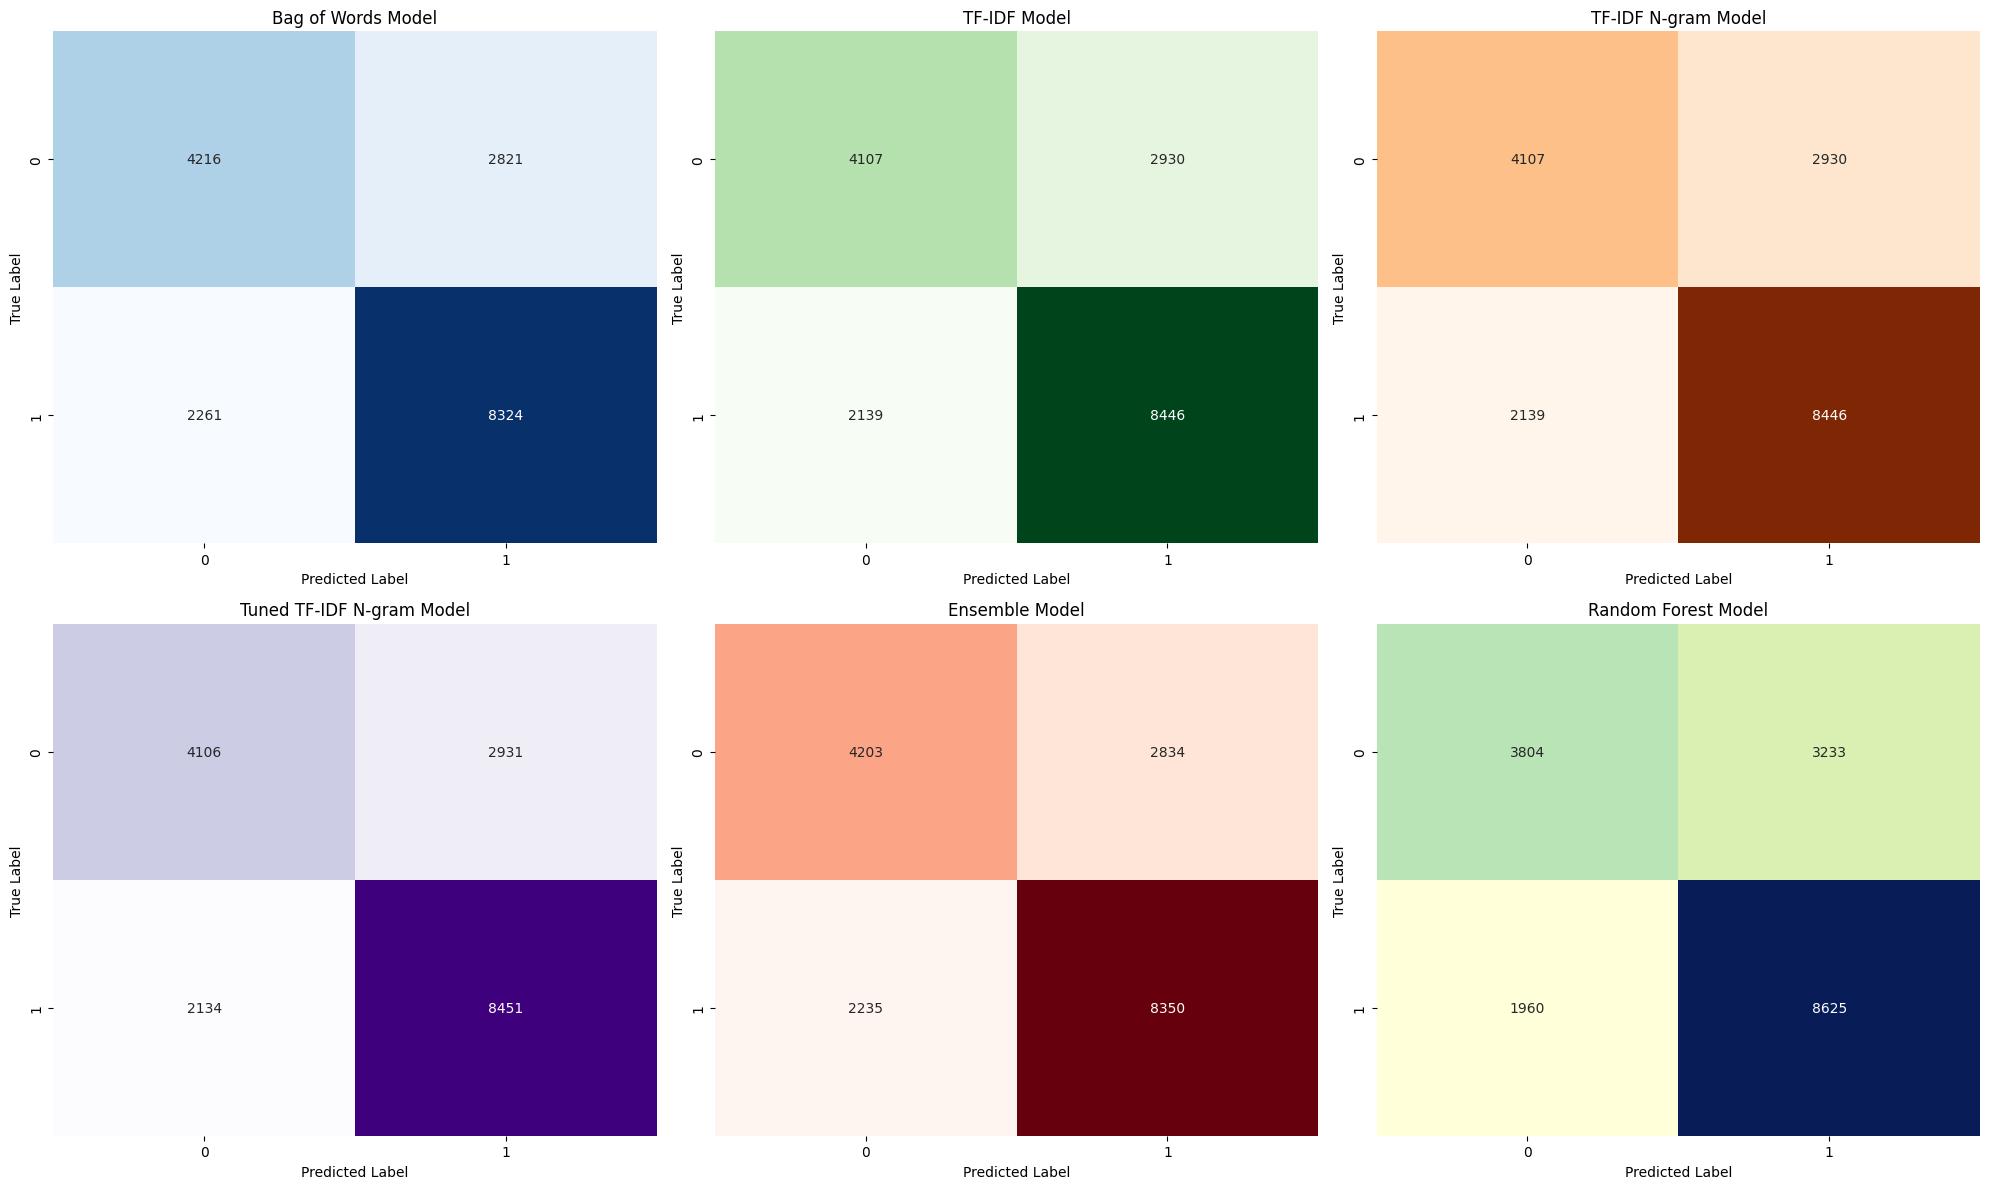


Examples where models disagree:

Text: liberals
True Label: 0
Model Predictions: BoW=1, TF-IDF=1, N-gram=1, Tuned=1, RF=0

Text: got banned uploading donald enjoy
True Label: 0
Model Predictions: BoW=0, TF-IDF=0, N-gram=0, Tuned=0, RF=1

Text: lesbians gay
True Label: 0
Model Predictions: BoW=1, TF-IDF=1, N-gram=1, Tuned=1, RF=0

Text: also facts unnecessary
True Label: 1
Model Predictions: BoW=1, TF-IDF=0, N-gram=0, Tuned=0, RF=1

Text: theres presidential election near future isnt
True Label: 1
Model Predictions: BoW=0, TF-IDF=0, N-gram=0, Tuned=0, RF=1


<Figure size 1200x600 with 0 Axes>

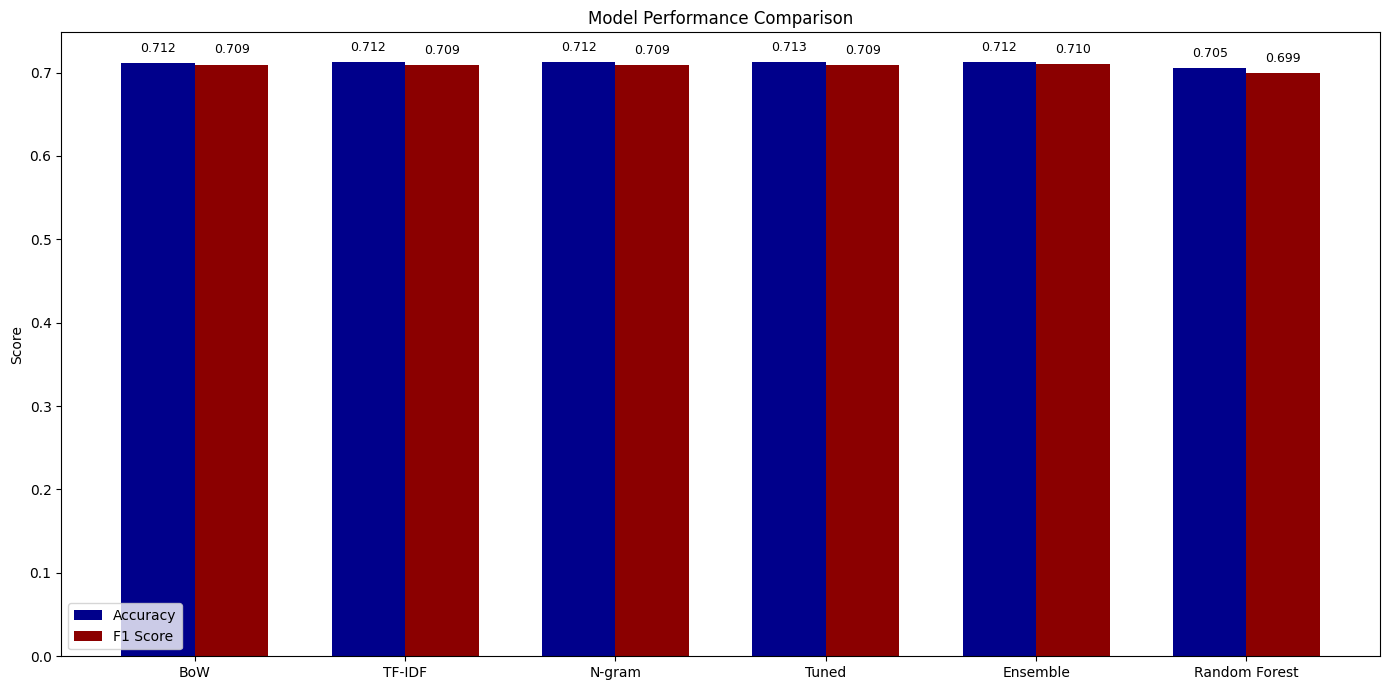

In [ ]:
# Visualize confusion matrices for all models
fig, axes = plt.subplots(2, 3, figsize=(20, 12))
axes = axes.flatten()

# BoW Confusion Matrix
cm_bow = confusion_matrix(y_val, y_val_pred_bow)
sns.heatmap(cm_bow, annot=True, fmt='d', cmap='Blues', cbar=False, ax=axes[0])
axes[0].set_title('Bag of Words Model')
axes[0].set_xlabel('Predicted Label')
axes[0].set_ylabel('True Label')

# TF-IDF Confusion Matrix
cm_tfidf = confusion_matrix(y_val, y_val_pred_tfidf)
sns.heatmap(cm_tfidf, annot=True, fmt='d', cmap='Greens', cbar=False, ax=axes[1])
axes[1].set_title('TF-IDF Model')
axes[1].set_xlabel('Predicted Label')
axes[1].set_ylabel('True Label')

# TF-IDF N-gram Confusion Matrix
cm_ngram = confusion_matrix(y_val, y_val_pred_tfidf_ngram)
sns.heatmap(cm_ngram, annot=True, fmt='d', cmap='Oranges', cbar=False, ax=axes[2])
axes[2].set_title('TF-IDF N-gram Model')
axes[2].set_xlabel('Predicted Label')
axes[2].set_ylabel('True Label')

# Tuned Model Confusion Matrix
cm_best = confusion_matrix(y_val, y_val_pred_best)
sns.heatmap(cm_best, annot=True, fmt='d', cmap='Purples', cbar=False, ax=axes[3])
axes[3].set_title('Tuned TF-IDF N-gram Model')
axes[3].set_xlabel('Predicted Label')
axes[3].set_ylabel('True Label')

# Ensemble Model Confusion Matrix
cm_ensemble = confusion_matrix(y_val, y_val_pred_ensemble)
sns.heatmap(cm_ensemble, annot=True, fmt='d', cmap='Reds', cbar=False, ax=axes[4])
axes[4].set_title('Ensemble Model')
axes[4].set_xlabel('Predicted Label')
axes[4].set_ylabel('True Label')

# Random Forest Confusion Matrix
cm_rf = confusion_matrix(y_val, y_val_pred_rf)
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='YlGnBu', cbar=False, ax=axes[5])
axes[5].set_title('Random Forest Model')
axes[5].set_xlabel('Predicted Label')
axes[5].set_ylabel('True Label')

plt.tight_layout()
plt.show()

# Error analysis: Find examples where models disagree
error_analysis_df = pd.DataFrame({
    'Text': X_val_text.values,
    'True Label': y_val.values,
    'BoW Prediction': y_val_pred_bow,
    'TF-IDF Prediction': y_val_pred_tfidf,
    'N-gram Prediction': y_val_pred_tfidf_ngram,
    'Tuned Prediction': y_val_pred_best,
    'RF Prediction': y_val_pred_rf
})

disagreement = error_analysis_df[
    (error_analysis_df['BoW Prediction'] != error_analysis_df['TF-IDF Prediction']) |
    (error_analysis_df['TF-IDF Prediction'] != error_analysis_df['N-gram Prediction']) |
    (error_analysis_df['N-gram Prediction'] != error_analysis_df['Tuned Prediction']) |
    (error_analysis_df['Tuned Prediction'] != error_analysis_df['RF Prediction'])
]

print("\nExamples where models disagree:")
for i, row in disagreement.head(5).iterrows():
    print(f"\nText: {row['Text']}")
    print(f"True Label: {row['True Label']}")
    print(f"Model Predictions: BoW={row['BoW Prediction']}, TF-IDF={row['TF-IDF Prediction']}, "
          f"N-gram={row['N-gram Prediction']}, Tuned={row['Tuned Prediction']}, RF={row['RF Prediction']}")

models = ['BoW', 'TF-IDF', 'N-gram', 'Tuned', 'Ensemble', 'Random Forest']
accuracies = [
    accuracy_score(y_val, y_val_pred_bow),
    accuracy_score(y_val, y_val_pred_tfidf),
    accuracy_score(y_val, y_val_pred_tfidf_ngram),
    accuracy_score(y_val, y_val_pred_best),
    accuracy_score(y_val, y_val_pred_ensemble),
    accuracy_score(y_val, y_val_pred_rf)
]
f1_scores = [
    f1_score(y_val, y_val_pred_bow, average='weighted'),
    f1_score(y_val, y_val_pred_tfidf, average='weighted'),
    f1_score(y_val, y_val_pred_tfidf_ngram, average='weighted'),
    f1_score(y_val, y_val_pred_best, average='weighted'),
    f1_score(y_val, y_val_pred_ensemble, average='weighted'),
    f1_score(y_val, y_val_pred_rf, average='weighted')
]

plt.figure(figsize=(12, 6))
x = np.arange(len(models))
width = 0.35

fig, ax = plt.subplots(figsize=(14, 7))
ax.bar(x - width/2, accuracies, width, label='Accuracy', color='darkblue')
ax.bar(x + width/2, f1_scores, width, label='F1 Score', color='darkred')

ax.set_ylabel('Score')
ax.set_title('Model Performance Comparison')
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.legend()

for i, v in enumerate(accuracies):
    ax.text(i - width/2, v + 0.01, f'{v:.3f}', ha='center', va='bottom', fontsize=9)

for i, v in enumerate(f1_scores):
    ax.text(i + width/2, v + 0.01, f'{v:.3f}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

#### Example Predictions

In [ ]:
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train_text)
tfidf_model = LogisticRegression(C=1.0, max_iter=1000, random_state=42)
tfidf_model.fit(X_train_tfidf, y_train)

def predict_sarcasm(text):
    processed_text = preprocess_text(text)
    vectorized_text = tfidf_vectorizer.transform([processed_text])
    prediction = tfidf_model.predict(vectorized_text)[0]
    probability = tfidf_model.predict_proba(vectorized_text)[0][1]
    return {
        'text': text,
        'is_sarcastic': bool(prediction),
        'probability': float(probability),
        'confidence': float(max(probability, 1-probability))
    }

sample_texts = [
    "I absolutely love when politicians keep their promises.",
    "The healthcare system is working perfectly for everyone.",
    "Climate change is definitely not a problem we need to worry about.",
    "This new policy will surely solve all our economic problems overnight."
]

print("\nSarcasm predictions for sample texts:")
for text in sample_texts:
    result = predict_sarcasm(text)
    print(f"\nText: {result['text']}")
    print(f"Is sarcastic: {result['is_sarcastic']}")
    print(f"Probability of sarcasm: {result['probability']:.3f}")
    print(f"Confidence: {result['confidence']:.3f}")


Sarcasm predictions for sample texts:

Text: I absolutely love when politicians keep their promises.
Is sarcastic: False
Probability of sarcasm: 0.500
Confidence: 0.500

Text: The healthcare system is working perfectly for everyone.
Is sarcastic: True
Probability of sarcasm: 0.922
Confidence: 0.922

Text: Climate change is definitely not a problem we need to worry about.
Is sarcastic: True
Probability of sarcasm: 0.916
Confidence: 0.916

Text: This new policy will surely solve all our economic problems overnight.
Is sarcastic: True
Probability of sarcasm: 0.925
Confidence: 0.925


## 5. LDA Topic Modeling


Top topics in sarcastic comments:
Topic #1: yes (15.7%), know (13.0%), good (12.4%), forgot (7.9%), totally (7.7%), thing (7.5%), country (5.2%), free (4.8%), poor (4.5%), america (4.4%)
Topic #2: like (17.8%), dont (16.0%), racist (6.7%), need (6.4%), youre (6.2%), clearly (5.9%), want (5.3%), money (5.2%), government (5.1%), going (5.0%)
Topic #3: yeah (20.7%), right (11.6%), sure (10.5%), thats (10.3%), really (5.2%), make (5.2%), think (5.0%), didnt (4.9%), way (4.6%), great (4.5%)
Topic #4: people (30.7%), white (9.0%), theyre (6.8%), man (6.0%), got (5.5%), black (5.3%), guys (4.8%), real (4.7%), things (4.4%), women (4.2%)
Topic #5: trump (13.9%), obviously (11.2%), hes (10.0%), doesnt (8.7%), obama (7.9%), world (6.8%), thought (5.9%), stop (5.8%), news (4.9%), guess (4.8%)

Top topics in non-sarcastic comments:
Topic #1: news (20.1%), good (10.1%), time (9.9%), thing (6.5%), probably (6.4%), states (5.7%), believe (5.5%), years (5.3%), bad (4.8%), lol (4.5%)
Topic #2: think (

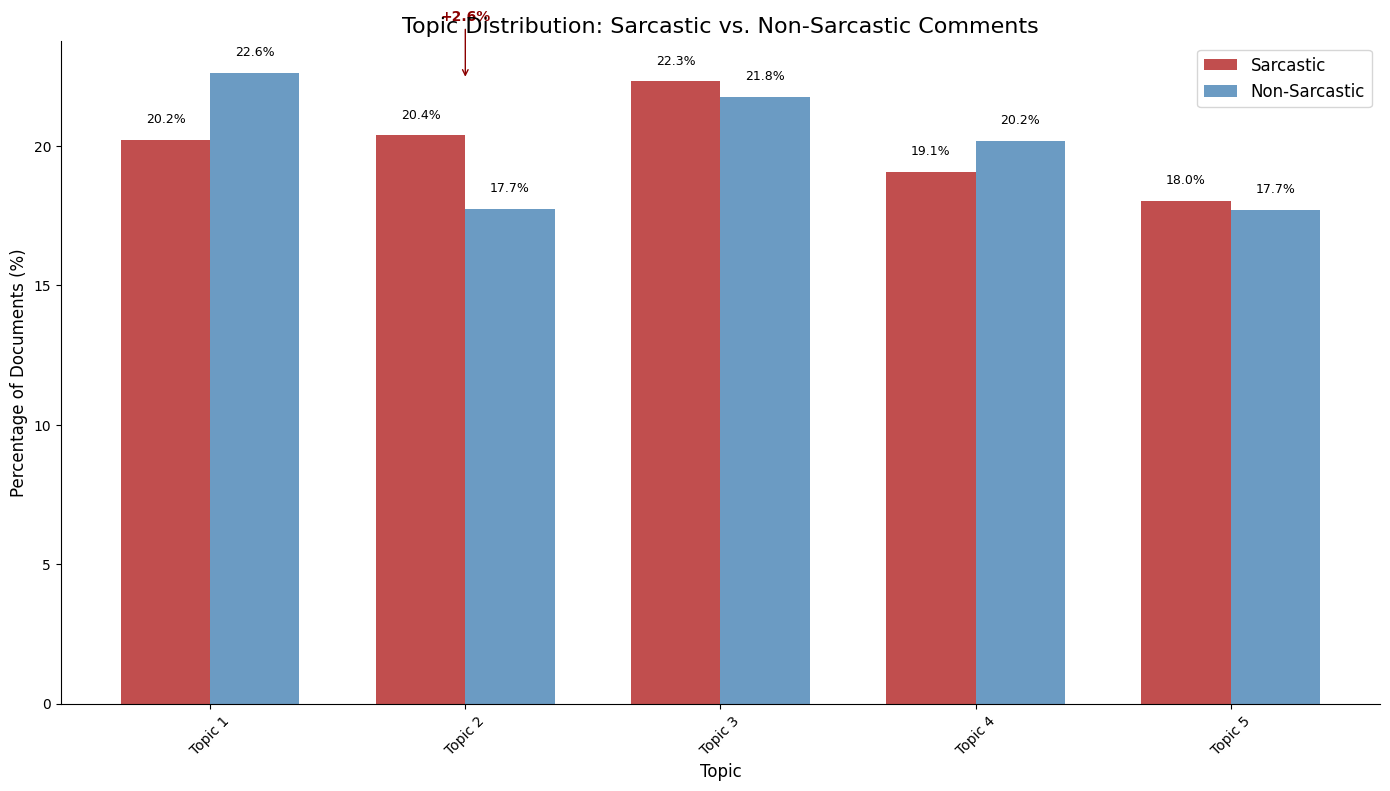


Topics sorted by how distinctive they are for sarcasm:
     Topic  Sarcastic %  Non-Sarcastic %  Difference
1  Topic 2    20.376013        17.739013    2.637000
2  Topic 3    22.310399        21.767862    0.542538
4  Topic 5    18.030657        17.714144    0.316514
3  Topic 4    19.069888        20.165559   -1.095671
0  Topic 1    20.213042        22.613422   -2.400380

Analyzing the most distinctively sarcastic topic: Topic 2


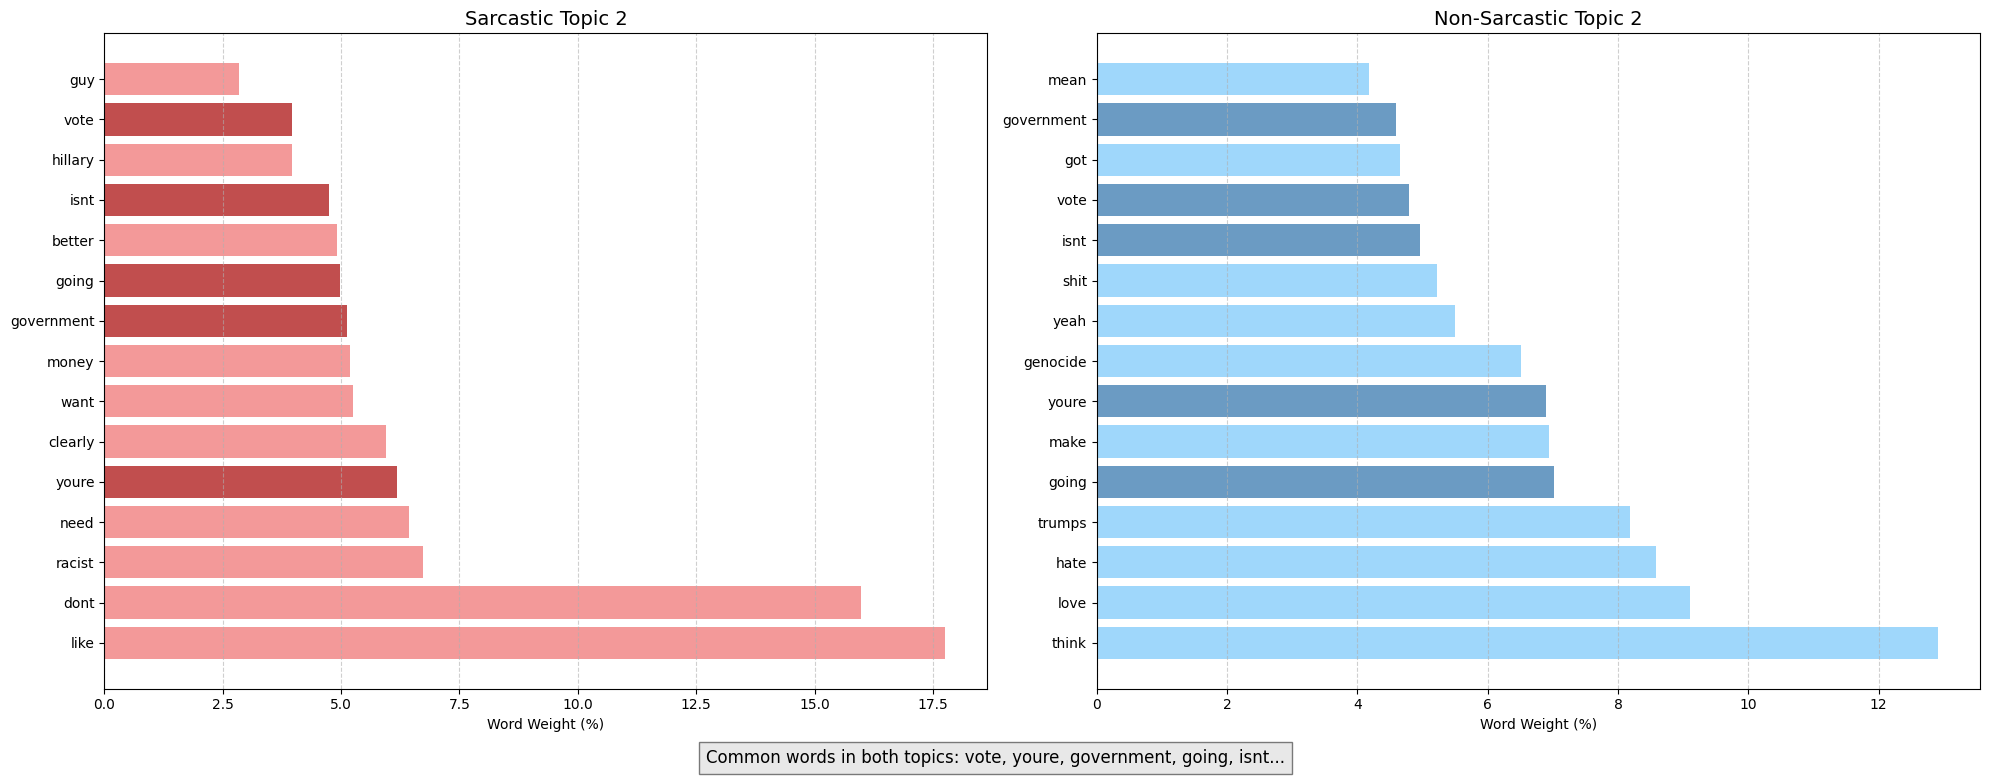


Analyzing the most distinctively non-sarcastic topic: Topic 1


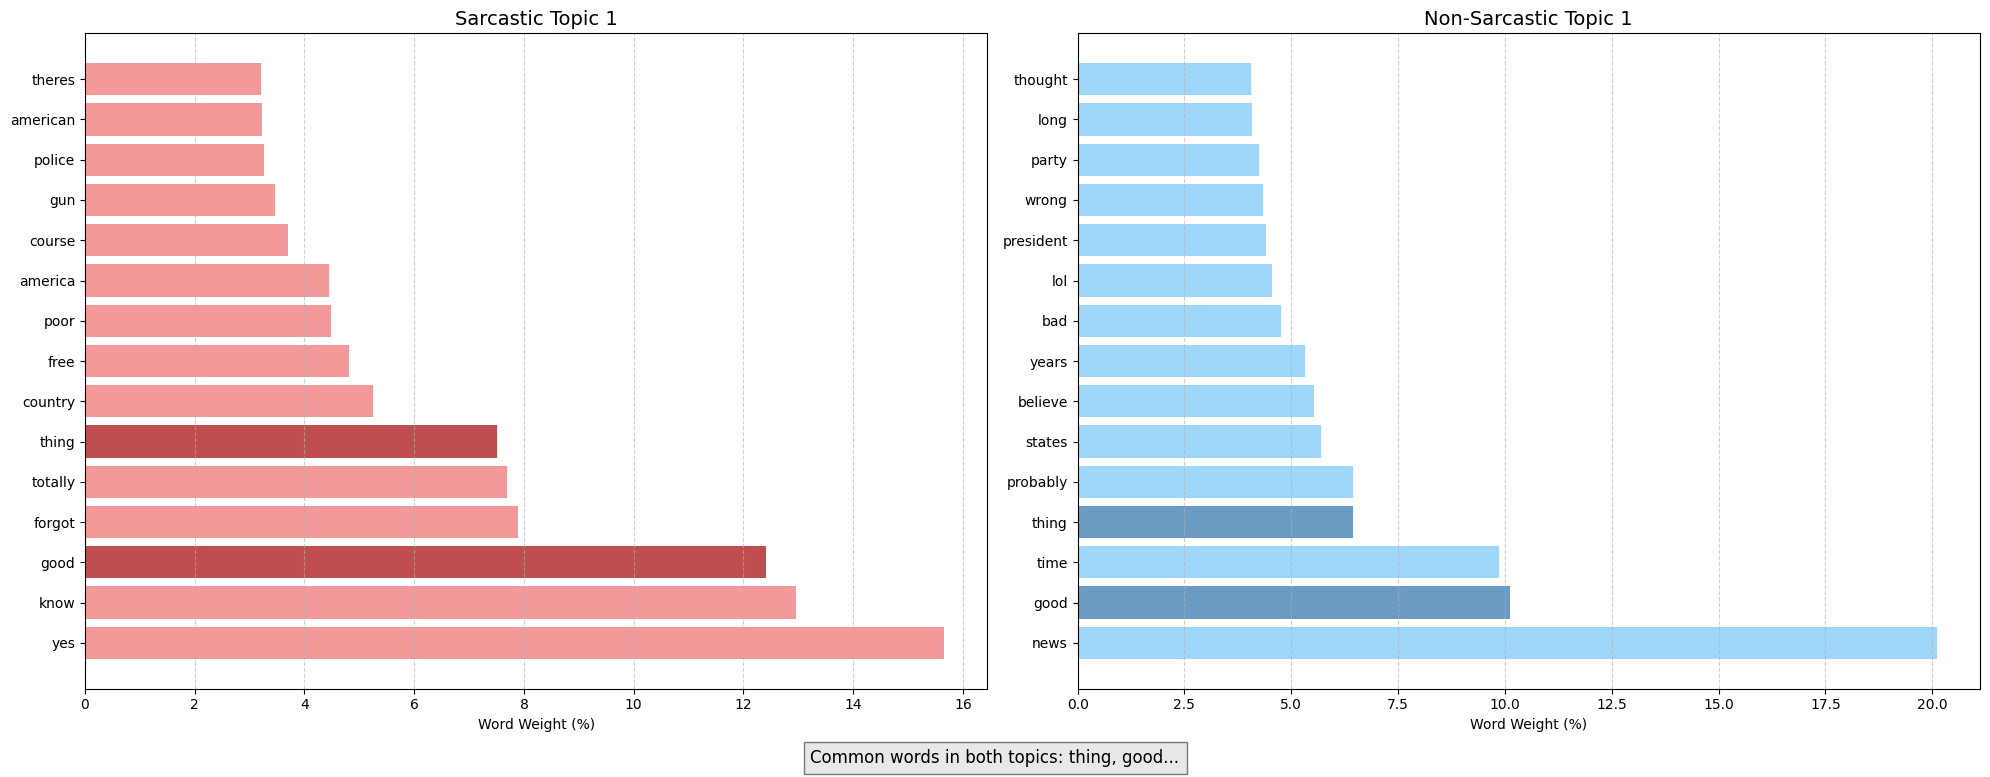


Representative sarcastic comments for Topic 2:
1. [0.862] reason support sanders capitulating compromising little bit change hillary would probably let republicans choose nominee partly...
2. [0.862] well would terrible inconvenience account arguments better suggest wish away forms punishment let anarchy reign...
3. [0.810] military isnt strong enough protect take money nasa wasting put towards kickass tanks...
4. [0.789] keep burning fossil fuel climate change hoax never happened...
5. [0.765] lul money team lullzzz money money money money...

Representative non-sarcastic comments for Topic 1:
1. [0.995] first lady united states first lady united states first lady united states first lady united states first lady united states first lady united states ...
2. [0.860] well cop normal selfcensorship news agencies constantly undergo regard cop misconduct shouldnt surprise theyve managed keep story local...
3. [0.826] antirussia comments sarcastic comment stupidity worldnews threads comme

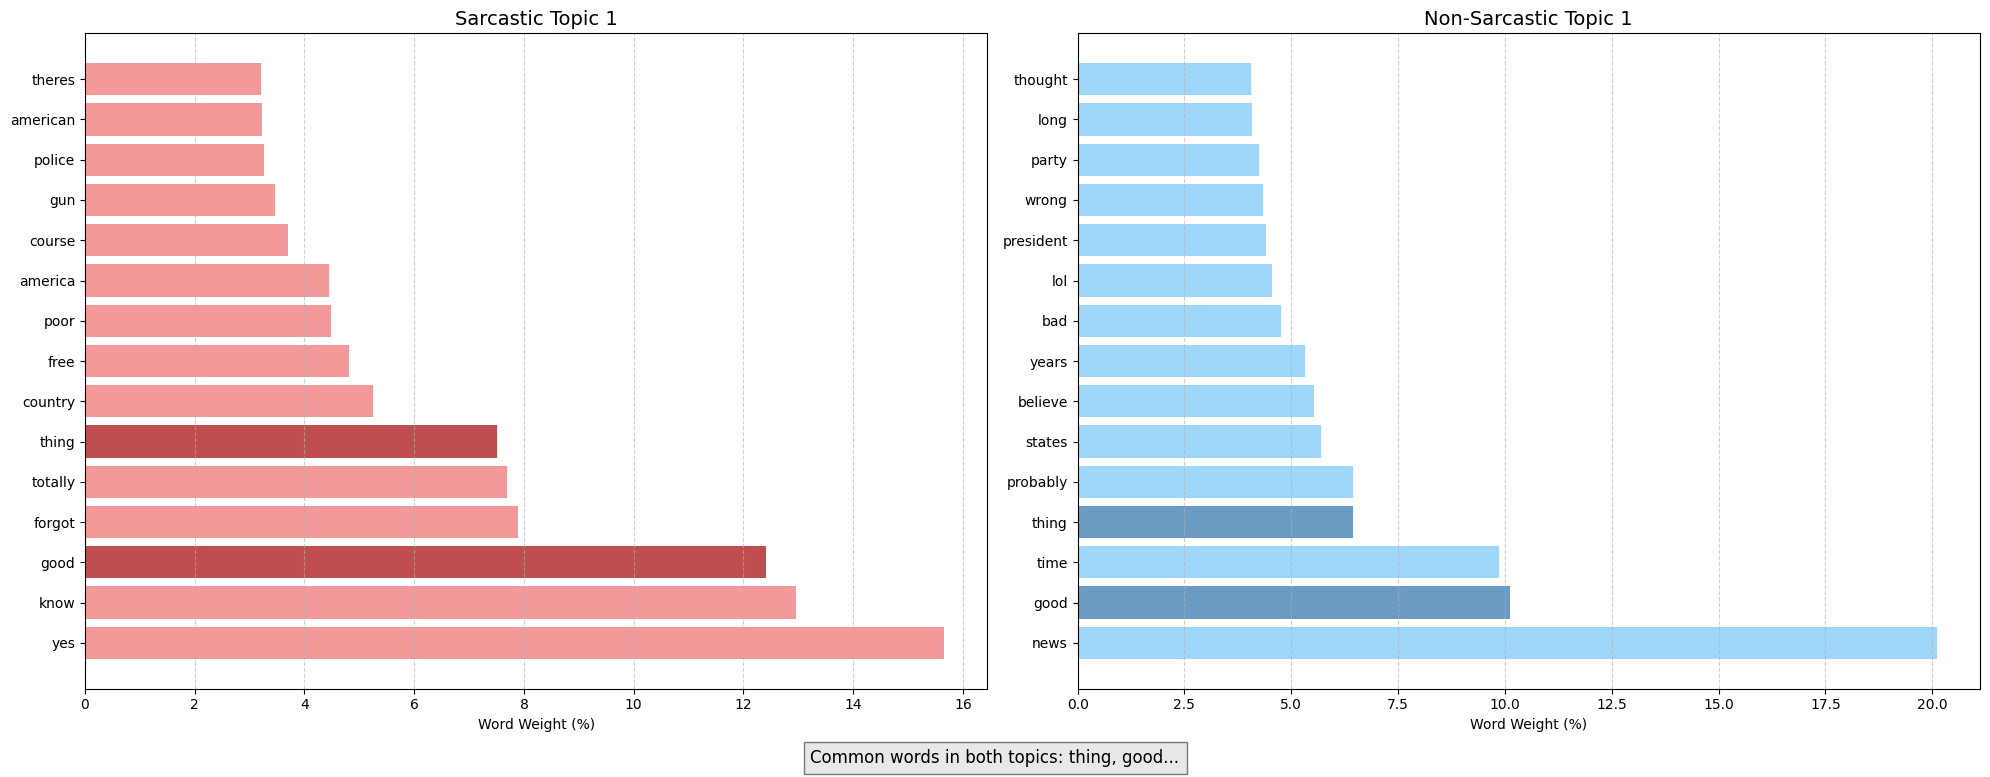

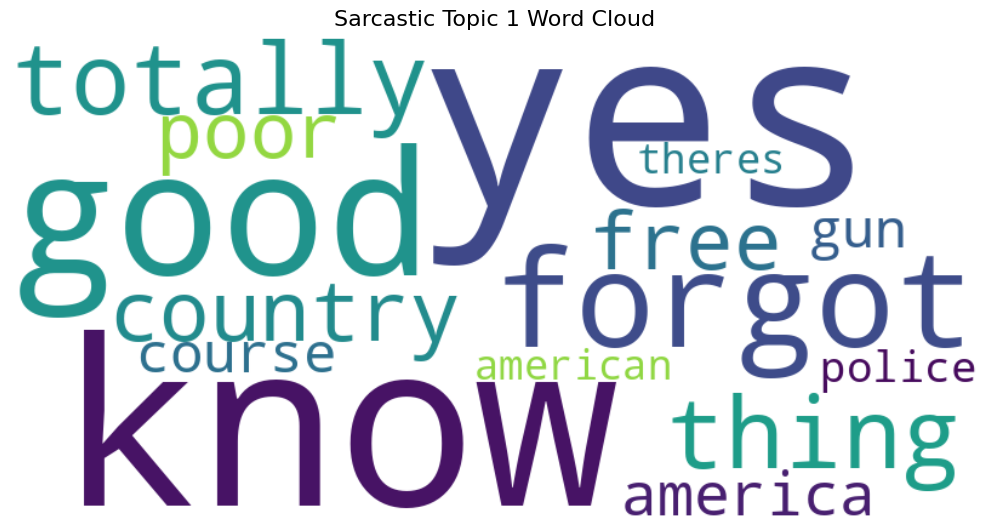


Exploring Topic 2


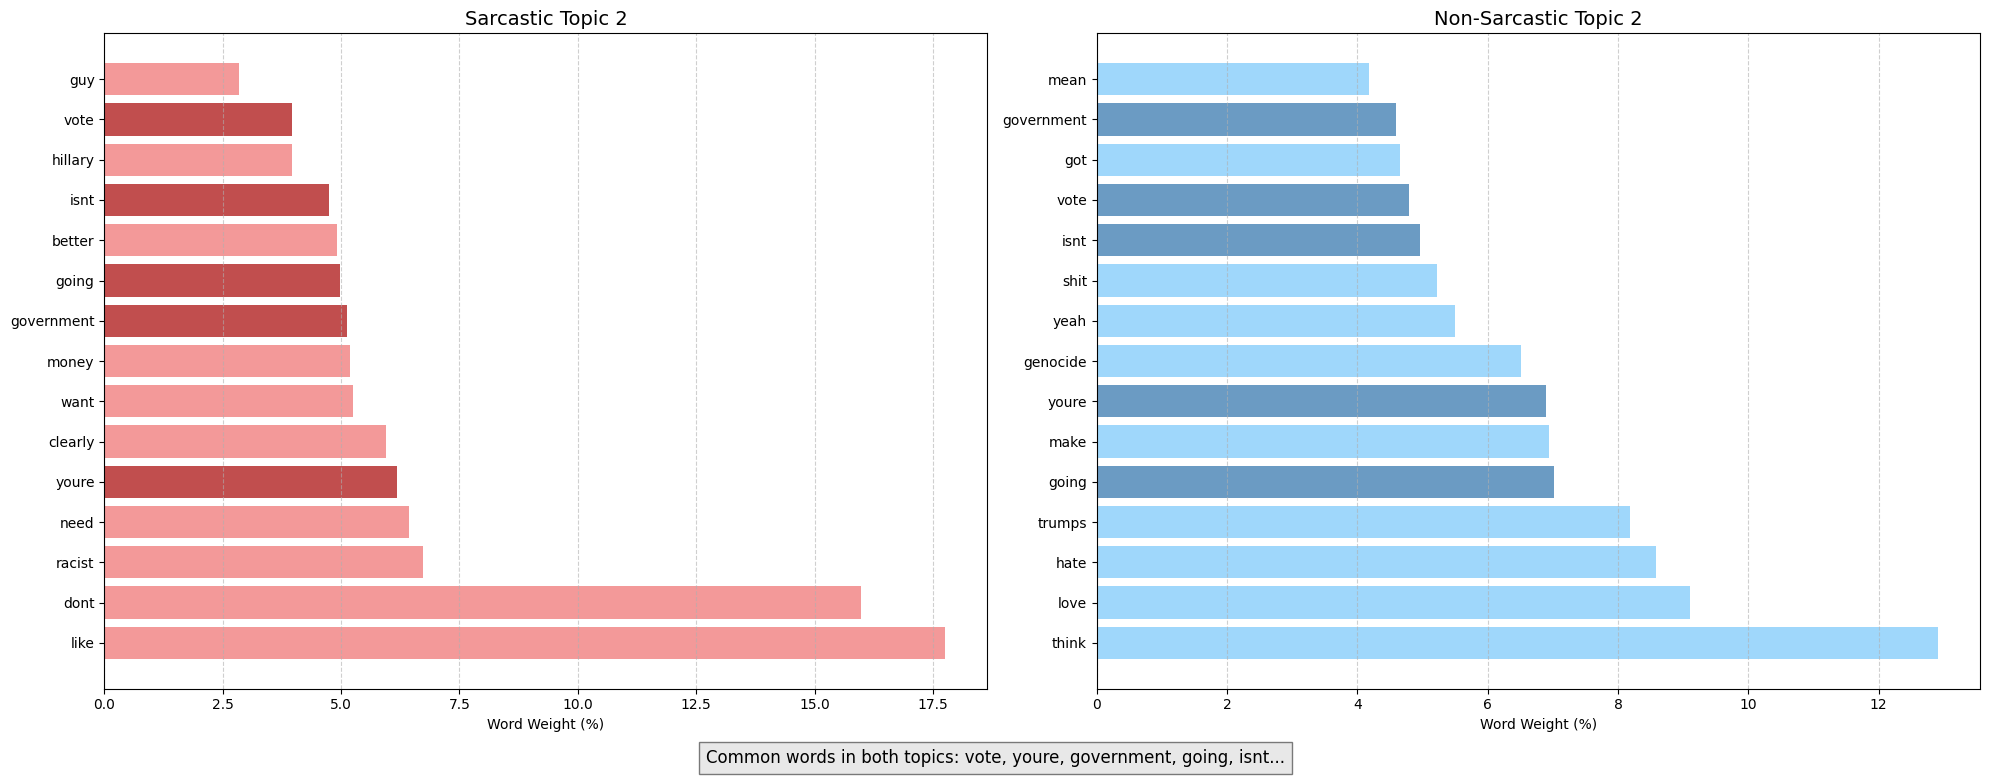

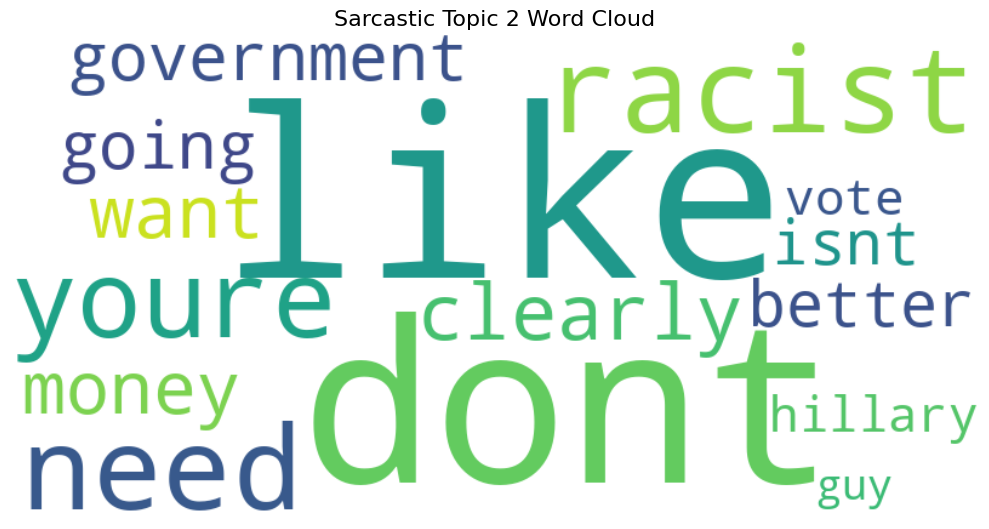


Exploring Topic 3


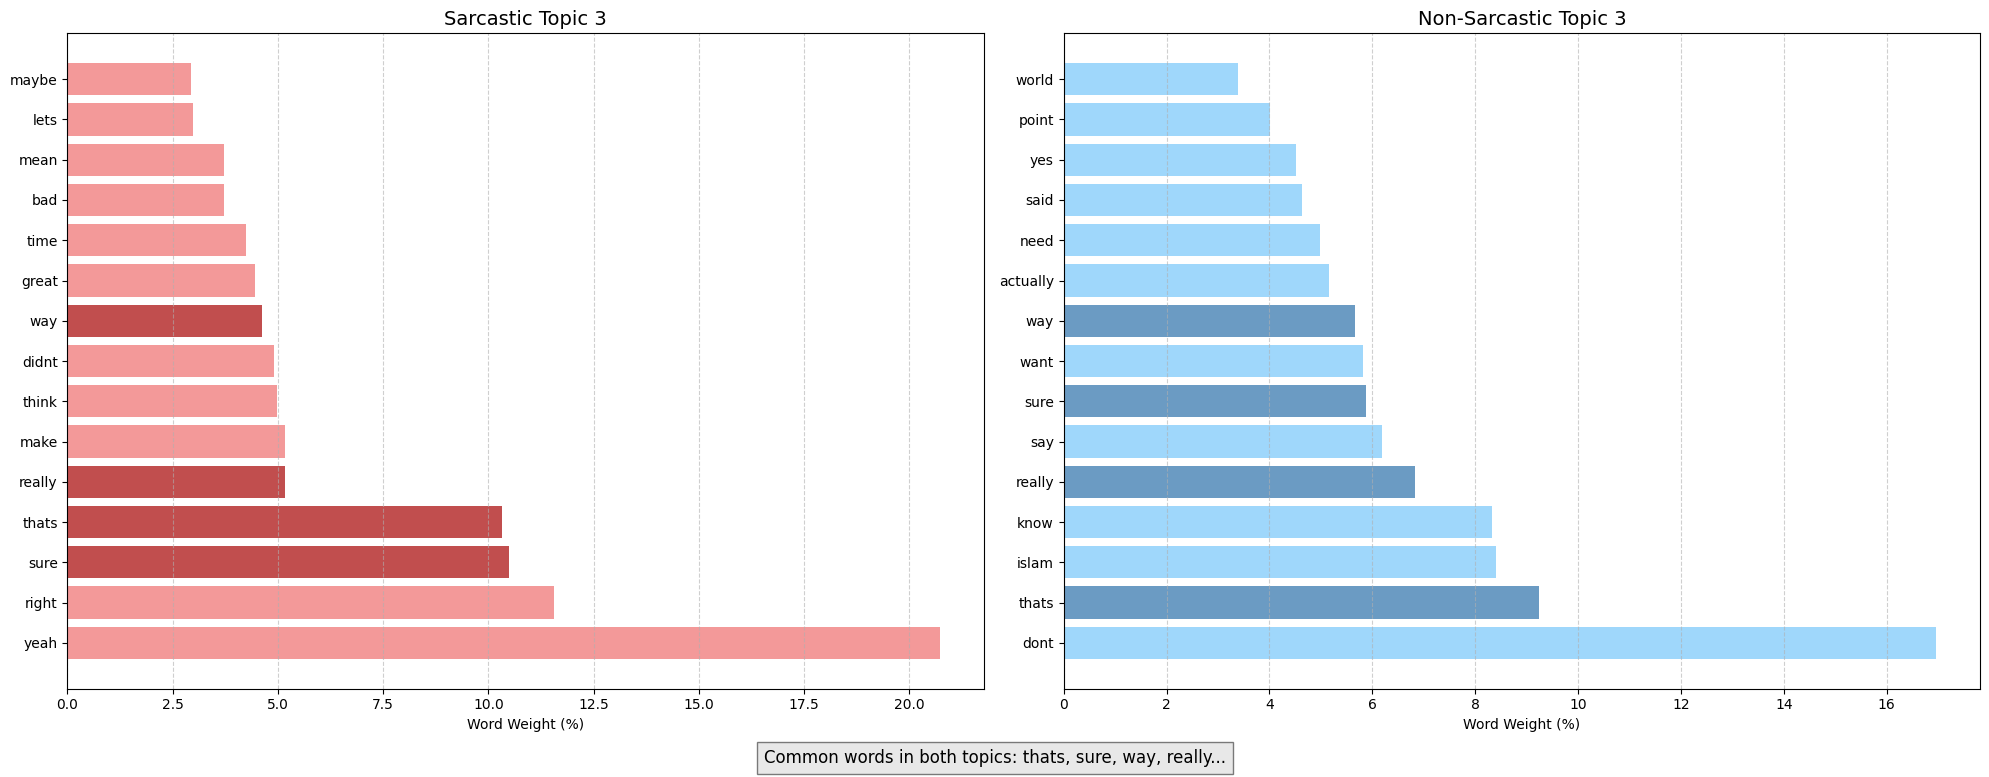

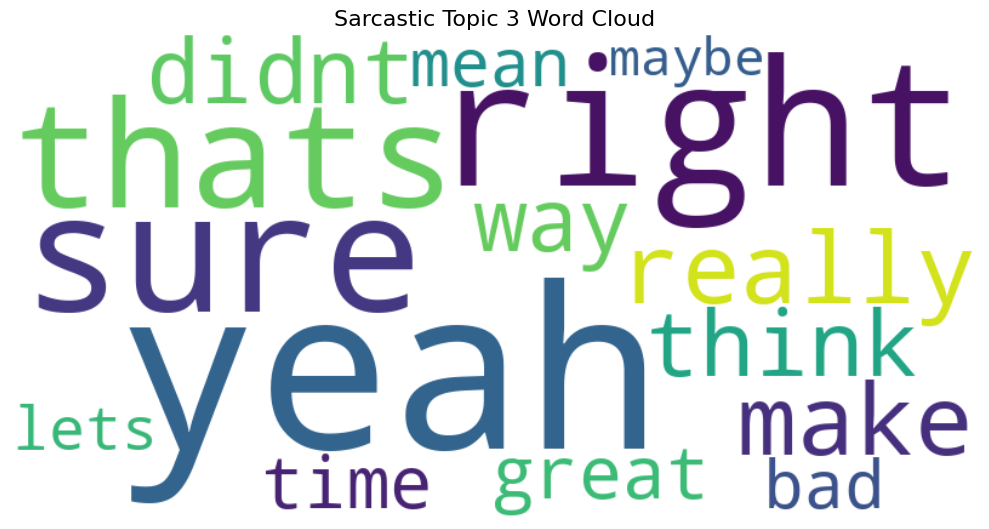


Topic matching examples:

Text: The government is really efficient at handling citizen needs. They never waste resources.
Matching topics:
- Sarcastic Topic 2 (score: 1)
- Sarcastic Topic 2 (score: 1)
- Sarcastic Topic 3 (score: 1)

Text: Climate change is the biggest threat we face. We need immediate action.
Matching topics:
- Sarcastic Topic 2 (score: 1)
- Sarcastic Topic 2 (score: 1)

Text: Politicians always tell the truth. It's amazing how honest they are.
Matching topics:

Text: The healthcare system needs reform to improve accessibility for everyone.
Matching topics:

Subreddits with most sarcastic comments in the most distinctive sarcastic topic:
               subreddit  label  topic_id  count
243             politics      1         1   3217
293            worldnews      1         1   1986
233                 news      1         1   1402
193           The_Donald      1         1    610
223           conspiracy      1         1    250
153          Libertarian      1         1 

In [ ]:
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer

n_topics = 5

lda_vectorizer = CountVectorizer(
    max_features=5000,
    stop_words='english',
    min_df=5,
    max_df=0.9
)

# Prepare documents for LDA analysis
sarcastic_docs = train_data[train_data['label'] == 1]['processed_comment'].tolist()
non_sarcastic_docs = train_data[train_data['label'] == 0]['processed_comment'].tolist()

# Process sarcastic comments
X_sarcastic = lda_vectorizer.fit_transform(sarcastic_docs)
feature_names = lda_vectorizer.get_feature_names_out()

# Create and fit LDA model for sarcastic comments with optimized parameters
lda_model_sarcastic = LatentDirichletAllocation(
    n_components=n_topics,
    max_iter=50,
    learning_method='online',
    learning_offset=50.,
    random_state=42,
    n_jobs=1,
    doc_topic_prior=0.5,
    topic_word_prior=0.05
)

lda_model_sarcastic.fit(X_sarcastic)

# Process non-sarcastic comments with the same vocabulary
X_non_sarcastic = lda_vectorizer.transform(non_sarcastic_docs)

# Create and fit LDA model for non-sarcastic comments with the same parameters
lda_model_non_sarcastic = LatentDirichletAllocation(
    n_components=n_topics,
    max_iter=50,
    learning_method='online',
    learning_offset=50.,
    random_state=42,
    n_jobs=1,
    doc_topic_prior=0.5,
    topic_word_prior=0.05
)
lda_model_non_sarcastic.fit(X_non_sarcastic)

# Function to extract and display top words for each topic
def get_top_words(model, feature_names, n_top_words=15):
    topics = []
    for topic_idx, topic in enumerate(model.components_):
        top_words_idx = topic.argsort()[:-n_top_words - 1:-1]
        top_words = [feature_names[i] for i in top_words_idx]
        topic_weights = [topic[i] for i in top_words_idx]
        topics.append({
            'words': top_words,
            'weights': topic_weights,
            'sum': sum(topic_weights)
        })
    return topics

# Get topics with weights
sarcastic_topics = get_top_words(lda_model_sarcastic, feature_names)
non_sarcastic_topics = get_top_words(lda_model_non_sarcastic, feature_names)

def print_topics_with_weights(topics, label):
    print(f"\nTop topics in {label} comments:")
    for idx, topic in enumerate(topics):
        words_weights = ", ".join([f"{w} ({round(wt/topic['sum']*100, 1)}%)"
                                 for w, wt in zip(topic['words'][:10], topic['weights'][:10])])
        print(f"Topic #{idx+1}: {words_weights}")

print_topics_with_weights(sarcastic_topics, "sarcastic")
print_topics_with_weights(non_sarcastic_topics, "non-sarcastic")

def plot_topic_wordcloud(topics, topic_num, title):
    # Create a dictionary of words and their weights
    words_dict = {topics[topic_num]['words'][i]: topics[topic_num]['weights'][i]
                 for i in range(len(topics[topic_num]['words']))}

    wordcloud = WordCloud(
        width=800,
        height=400,
        background_color='white',
        max_words=50,
        contour_width=3,
        contour_color='steelblue',
        prefer_horizontal=1.0
    ).generate_from_frequencies(words_dict)

    plt.figure(figsize=(10, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title, fontsize=16)
    plt.tight_layout()
    plt.show()

def compare_topics(sarcastic_topics, non_sarcastic_topics, topic_num):
    plt.figure(figsize=(20, 8))

    # Common words
    sarcastic_words = set(sarcastic_topics[topic_num]['words'][:20])
    non_sarcastic_words = set(non_sarcastic_topics[topic_num]['words'][:20])
    common_words = sarcastic_words.intersection(non_sarcastic_words)

    # Get word weights
    s_word_dict = {w: sarcastic_topics[topic_num]['weights'][i]/sarcastic_topics[topic_num]['sum']*100
                  for i, w in enumerate(sarcastic_topics[topic_num]['words'][:20])}

    ns_word_dict = {w: non_sarcastic_topics[topic_num]['weights'][i]/non_sarcastic_topics[topic_num]['sum']*100
                   for i, w in enumerate(non_sarcastic_topics[topic_num]['words'][:20])}

    s_words = list(s_word_dict.keys())[:15]
    s_vals = [s_word_dict[w] for w in s_words]

    ns_words = list(ns_word_dict.keys())[:15]
    ns_vals = [ns_word_dict[w] for w in ns_words]

    plt.subplot(1, 2, 1)
    colors = ['firebrick' if w in common_words else 'lightcoral' for w in s_words]
    plt.barh(range(len(s_words)), s_vals, color=colors, alpha=0.8)
    plt.yticks(range(len(s_words)), s_words)
    plt.xlabel('Word Weight (%)')
    plt.title(f'Sarcastic Topic {topic_num+1}', fontsize=14)
    plt.grid(axis='x', linestyle='--', alpha=0.6)

    plt.subplot(1, 2, 2)
    colors = ['steelblue' if w in common_words else 'lightskyblue' for w in ns_words]
    plt.barh(range(len(ns_words)), ns_vals, color=colors, alpha=0.8)
    plt.yticks(range(len(ns_words)), ns_words)
    plt.xlabel('Word Weight (%)')
    plt.title(f'Non-Sarcastic Topic {topic_num+1}', fontsize=14)
    plt.grid(axis='x', linestyle='--', alpha=0.6)

    common_words_list = list(common_words)[:5]
    if common_words_list:
        common_words_text = ', '.join(common_words_list)
        plt.figtext(0.5, 0.01, f'Common words in both topics: {common_words_text}...',
                   ha='center', fontsize=12, bbox={'facecolor':'lightgrey', 'alpha':0.5, 'pad':5})

    plt.tight_layout(rect=[0, 0.03, 1, 0.97])
    plt.show()

def get_document_topics(model, X):
    return model.transform(X)

# Get document-topic distributions
sarcastic_doc_topics = get_document_topics(lda_model_sarcastic, X_sarcastic)
non_sarcastic_doc_topics = get_document_topics(lda_model_non_sarcastic, X_non_sarcastic)

# Get dominant topic for each document
sarcastic_dominant_topics = np.argmax(sarcastic_doc_topics, axis=1)
non_sarcastic_dominant_topics = np.argmax(non_sarcastic_doc_topics, axis=1)

# Count topic frequencies
sarcastic_topic_counts = np.bincount(sarcastic_dominant_topics, minlength=n_topics)
non_sarcastic_topic_counts = np.bincount(non_sarcastic_dominant_topics, minlength=n_topics)

# Normalize to get %
sarcastic_topic_pct = sarcastic_topic_counts / sarcastic_topic_counts.sum() * 100
non_sarcastic_topic_pct = non_sarcastic_topic_counts / non_sarcastic_topic_counts.sum() * 100

# Plot topic distribution comparison
fig, ax = plt.subplots(figsize=(14, 8))
width = 0.35
x = np.arange(n_topics)

sarcastic_bars = ax.bar(x - width/2, sarcastic_topic_pct, width, label='Sarcastic', color='firebrick', alpha=0.8)
non_sarcastic_bars = ax.bar(x + width/2, non_sarcastic_topic_pct, width, label='Non-Sarcastic', color='steelblue', alpha=0.8)

for i, v in enumerate(sarcastic_topic_pct):
    ax.text(i - width/2, v + 0.5, f'{v:.1f}%', ha='center', va='bottom', fontsize=9)

for i, v in enumerate(non_sarcastic_topic_pct):
    ax.text(i + width/2, v + 0.5, f'{v:.1f}%', ha='center', va='bottom', fontsize=9)

# Calculate the difference between sarcastic and non-sarcastic percentages
diff_pct = sarcastic_topic_pct - non_sarcastic_topic_pct

# Add annotations for the largest differences
for i, diff in enumerate(diff_pct):
    if abs(diff) > 2:
        color = 'darkred' if diff > 0 else 'darkblue'
        x_pos = i
        y_pos = max(sarcastic_topic_pct[i], non_sarcastic_topic_pct[i]) + 2
        ax.annotate(f'{diff:+.1f}%', xy=(x_pos, y_pos), xytext=(x_pos, y_pos + 2),
                   arrowprops=dict(arrowstyle='->', color=color),
                   ha='center', va='bottom', color=color, fontweight='bold')

ax.set_xticks(x)
ax.set_xticklabels([f'Topic {i+1}' for i in range(n_topics)])
ax.set_ylabel('Percentage of Documents (%)', fontsize=12)
ax.set_xlabel('Topic', fontsize=12)
ax.set_title('Topic Distribution: Sarcastic vs. Non-Sarcastic Comments', fontsize=16)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.legend(loc='upper right', fontsize=12)

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Identify the most distinctive topics (largest difference)
topic_diff_df = pd.DataFrame({
    'Topic': [f'Topic {i+1}' for i in range(n_topics)],
    'Sarcastic %': sarcastic_topic_pct,
    'Non-Sarcastic %': non_sarcastic_topic_pct,
    'Difference': sarcastic_topic_pct - non_sarcastic_topic_pct
})
topic_diff_df = topic_diff_df.sort_values('Difference', ascending=False)

# Display the topics sorted by how distinctive they are for sarcasm
print("\nTopics sorted by how distinctive they are for sarcasm:")
print(topic_diff_df[['Topic', 'Sarcastic %', 'Non-Sarcastic %', 'Difference']])

# Find representative documents for each topic
def get_representative_docs(doc_topic_matrix, documents, topic_idx, n_docs=5):
    topic_scores = doc_topic_matrix[:, topic_idx]
    top_indices = np.argsort(topic_scores)[-n_docs:][::-1]
    return [(documents[i], topic_scores[i]) for i in top_indices]

# Get indexes of most distinctive topics
most_sarcastic_topic_idx = topic_diff_df.iloc[0]['Topic']
most_sarcastic_topic_idx = int(most_sarcastic_topic_idx.split()[-1]) - 1

most_non_sarcastic_topic_idx = topic_diff_df.iloc[-1]['Topic']
most_non_sarcastic_topic_idx = int(most_non_sarcastic_topic_idx.split()[-1]) - 1

print(f"\nAnalyzing the most distinctively sarcastic topic: Topic {most_sarcastic_topic_idx+1}")
compare_topics(sarcastic_topics, non_sarcastic_topics, most_sarcastic_topic_idx)

print(f"\nAnalyzing the most distinctively non-sarcastic topic: Topic {most_non_sarcastic_topic_idx+1}")
compare_topics(sarcastic_topics, non_sarcastic_topics, most_non_sarcastic_topic_idx)

rep_sarcastic_docs = get_representative_docs(
    sarcastic_doc_topics, sarcastic_docs, most_sarcastic_topic_idx
)

print(f"\nRepresentative sarcastic comments for Topic {most_sarcastic_topic_idx+1}:")
for i, (doc, score) in enumerate(rep_sarcastic_docs):
    print(f"{i+1}. [{score:.3f}] {doc[:150]}...")

rep_non_sarcastic_docs = get_representative_docs(
    non_sarcastic_doc_topics, non_sarcastic_docs, most_non_sarcastic_topic_idx
)

print(f"\nRepresentative non-sarcastic comments for Topic {most_non_sarcastic_topic_idx+1}:")
for i, (doc, score) in enumerate(rep_non_sarcastic_docs):
    print(f"{i+1}. [{score:.3f}] {doc[:150]}...")

# Interactive topic explorer (a few examples)
for topic_idx in range(min(3, n_topics)):
    print(f"\nExploring Topic {topic_idx+1}")
    compare_topics(sarcastic_topics, non_sarcastic_topics, topic_idx)
    plot_topic_wordcloud(sarcastic_topics, topic_idx, f"Sarcastic Topic {topic_idx+1} Word Cloud")

# Create a dictionary of topics with their keywords for later use
topic_keywords = {}
for i in range(n_topics):
    s_topic_words = sarcastic_topics[i]['words'][:10]
    # Store in dictionary
    topic_keywords[f'sarcastic_topic_{i+1}'] = s_topic_words
    topic_keywords[f'non_sarcastic_topic_{i+1}'] = s_topic_words

# Function to match text to topics
def match_text_to_topics(text, topic_keywords, n_matches=3):
    if not isinstance(text, str):
        return []

    # Preprocess the text
    processed_text = preprocess_text(text)
    words = processed_text.split()

    # Calculate matches for each topic
    topic_matches = {}
    for topic, keywords in topic_keywords.items():
        matches = sum(1 for word in words if word in keywords)
        if matches > 0:
            topic_matches[topic] = matches

    sorted_matches = sorted(topic_matches.items(), key=lambda x: x[1], reverse=True)

    return sorted_matches[:n_matches]

# Example usage of topic matching
example_texts = [
    "The government is really efficient at handling citizen needs. They never waste resources.",
    "Climate change is the biggest threat we face. We need immediate action.",
    "Politicians always tell the truth. It's amazing how honest they are.",
    "The healthcare system needs reform to improve accessibility for everyone."
]

print("\nTopic matching examples:")
for text in example_texts:
    matches = match_text_to_topics(text, topic_keywords)
    print(f"\nText: {text}")
    print("Matching topics:")
    for topic, score in matches:
        topic_type = "Sarcastic" if "sarcastic_topic" in topic else "Non-sarcastic"
        topic_num = topic.split('_')[-1]
        print(f"- {topic_type} Topic {topic_num} (score: {score})")

# Assign topics to the dataset for future analysis
train_data_topics = train_data.copy()
train_data_topics['topic_id'] = -1

# Use the appropriate model for each comment
for idx, row in train_data_topics.iterrows():
    text = row['processed_comment']
    text_vector = lda_vectorizer.transform([text])

    if row['label'] == 1:  # Sarcastic comment
        topic_dist = lda_model_sarcastic.transform(text_vector)[0]
        dominant_topic = np.argmax(topic_dist)
        train_data_topics.loc[idx, 'topic_id'] = dominant_topic
    else:  # Non-sarcastic comment
        topic_dist = lda_model_non_sarcastic.transform(text_vector)[0]
        dominant_topic = np.argmax(topic_dist)
        train_data_topics.loc[idx, 'topic_id'] = dominant_topic + n_topics

# Examine topics by subreddit
topic_by_subreddit = train_data_topics.groupby(['subreddit', 'label', 'topic_id']).size().reset_index(name='count')

# Find which subreddits have the most sarcastic comments in specific topics
sarcastic_topics_by_subreddit = topic_by_subreddit[
    (topic_by_subreddit['label'] == 1) &
    (topic_by_subreddit['topic_id'] == most_sarcastic_topic_idx)
].sort_values('count', ascending=False)

print("\nSubreddits with most sarcastic comments in the most distinctive sarcastic topic:")
print(sarcastic_topics_by_subreddit.head(10))

# 6. Evaluating the Impact of Subreddits on Sarcasm

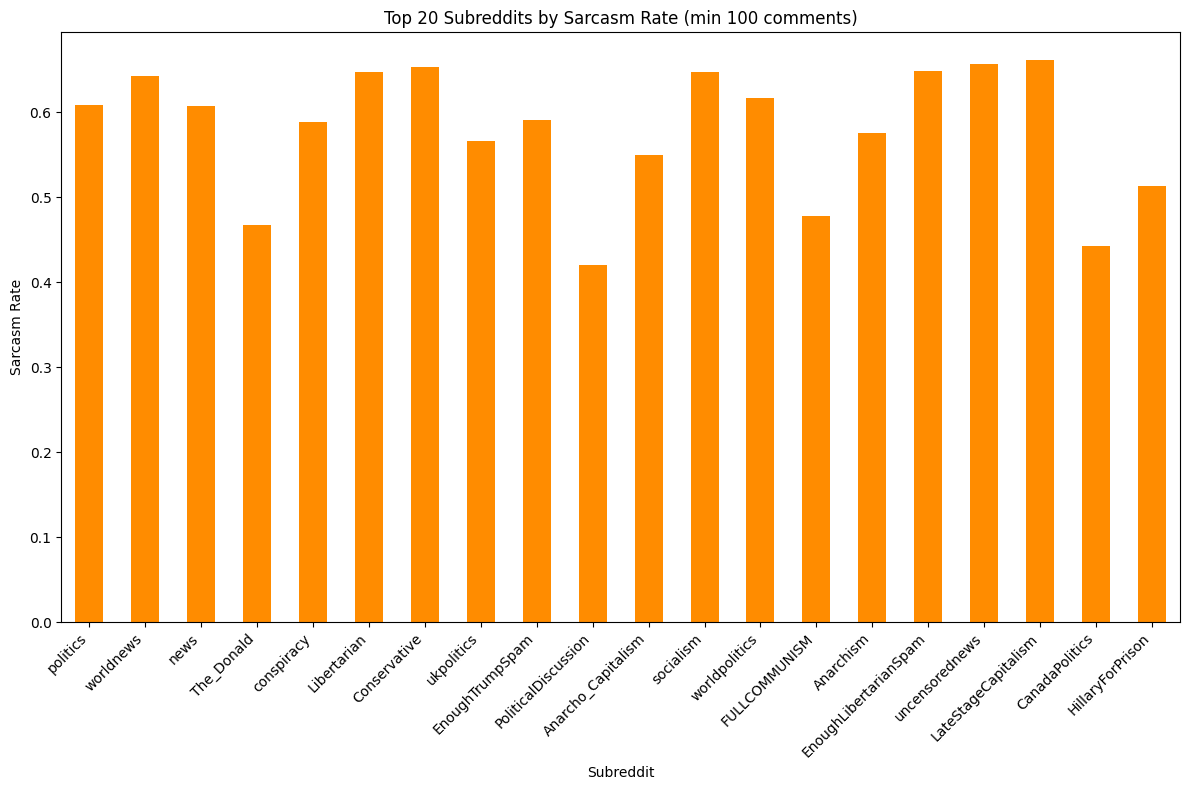

Subreddit-Only Model Evaluation:
Accuracy: 0.6312
F1 Score (weighted): 0.5911


In [ ]:
# Analyzing sarcasm prevalence by subreddit
subreddit_sarcasm = train_data.groupby('subreddit')['label'].mean().sort_values(ascending=False)
subreddit_counts = train_data.groupby('subreddit').size().sort_values(ascending=False)

# Filter for subreddits with a minimum number of comments
min_comments = 100
filtered_subreddits = subreddit_counts[subreddit_counts >= min_comments].index
subreddit_sarcasm_filtered = subreddit_sarcasm[filtered_subreddits]

plt.figure(figsize=(12, 8))
subreddit_sarcasm_filtered.head(20).plot(kind='bar', color='darkorange')
plt.title('Top 20 Subreddits by Sarcasm Rate (min 100 comments)')
plt.ylabel('Sarcasm Rate')
plt.xlabel('Subreddit')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Create a feature for subreddit to see if it improves classification
# One-hot encode the top subreddits
top_subreddits = subreddit_counts.head(50).index.tolist()
train_data_sub = train_data.copy()
train_data_sub['subreddit'] = train_data_sub['subreddit'].apply(lambda x: x if x in top_subreddits else 'other')
subreddit_dummies = pd.get_dummies(train_data_sub['subreddit'], prefix='subreddit')
train_data_with_subreddit = pd.concat([train_data_sub, subreddit_dummies], axis=1)

# Split data with subreddit features
X_train_sub, X_val_sub, y_train_sub, y_val_sub = train_test_split(
    train_data_with_subreddit.drop(['label', 'comment', 'author', 'score', 'ups', 'downs', 'date', 'created_utc', 'parent_comment', 'processed_comment', 'comment_length', 'lda_tokens', 'subreddit'], axis=1, errors='ignore'),
    train_data_with_subreddit['label'],
    test_size=0.2,
    random_state=42
)

# Train a model with subreddit features
subreddit_model = LogisticRegression(C=1.0, max_iter=1000, random_state=42)
subreddit_model.fit(X_train_sub, y_train_sub)

# Evaluate
y_val_pred_sub = subreddit_model.predict(X_val_sub)
print("Subreddit-Only Model Evaluation:")
print(f"Accuracy: {accuracy_score(y_val_sub, y_val_pred_sub):.4f}")
print(f"F1 Score (weighted): {f1_score(y_val_sub, y_val_pred_sub, average='weighted'):.4f}")